## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

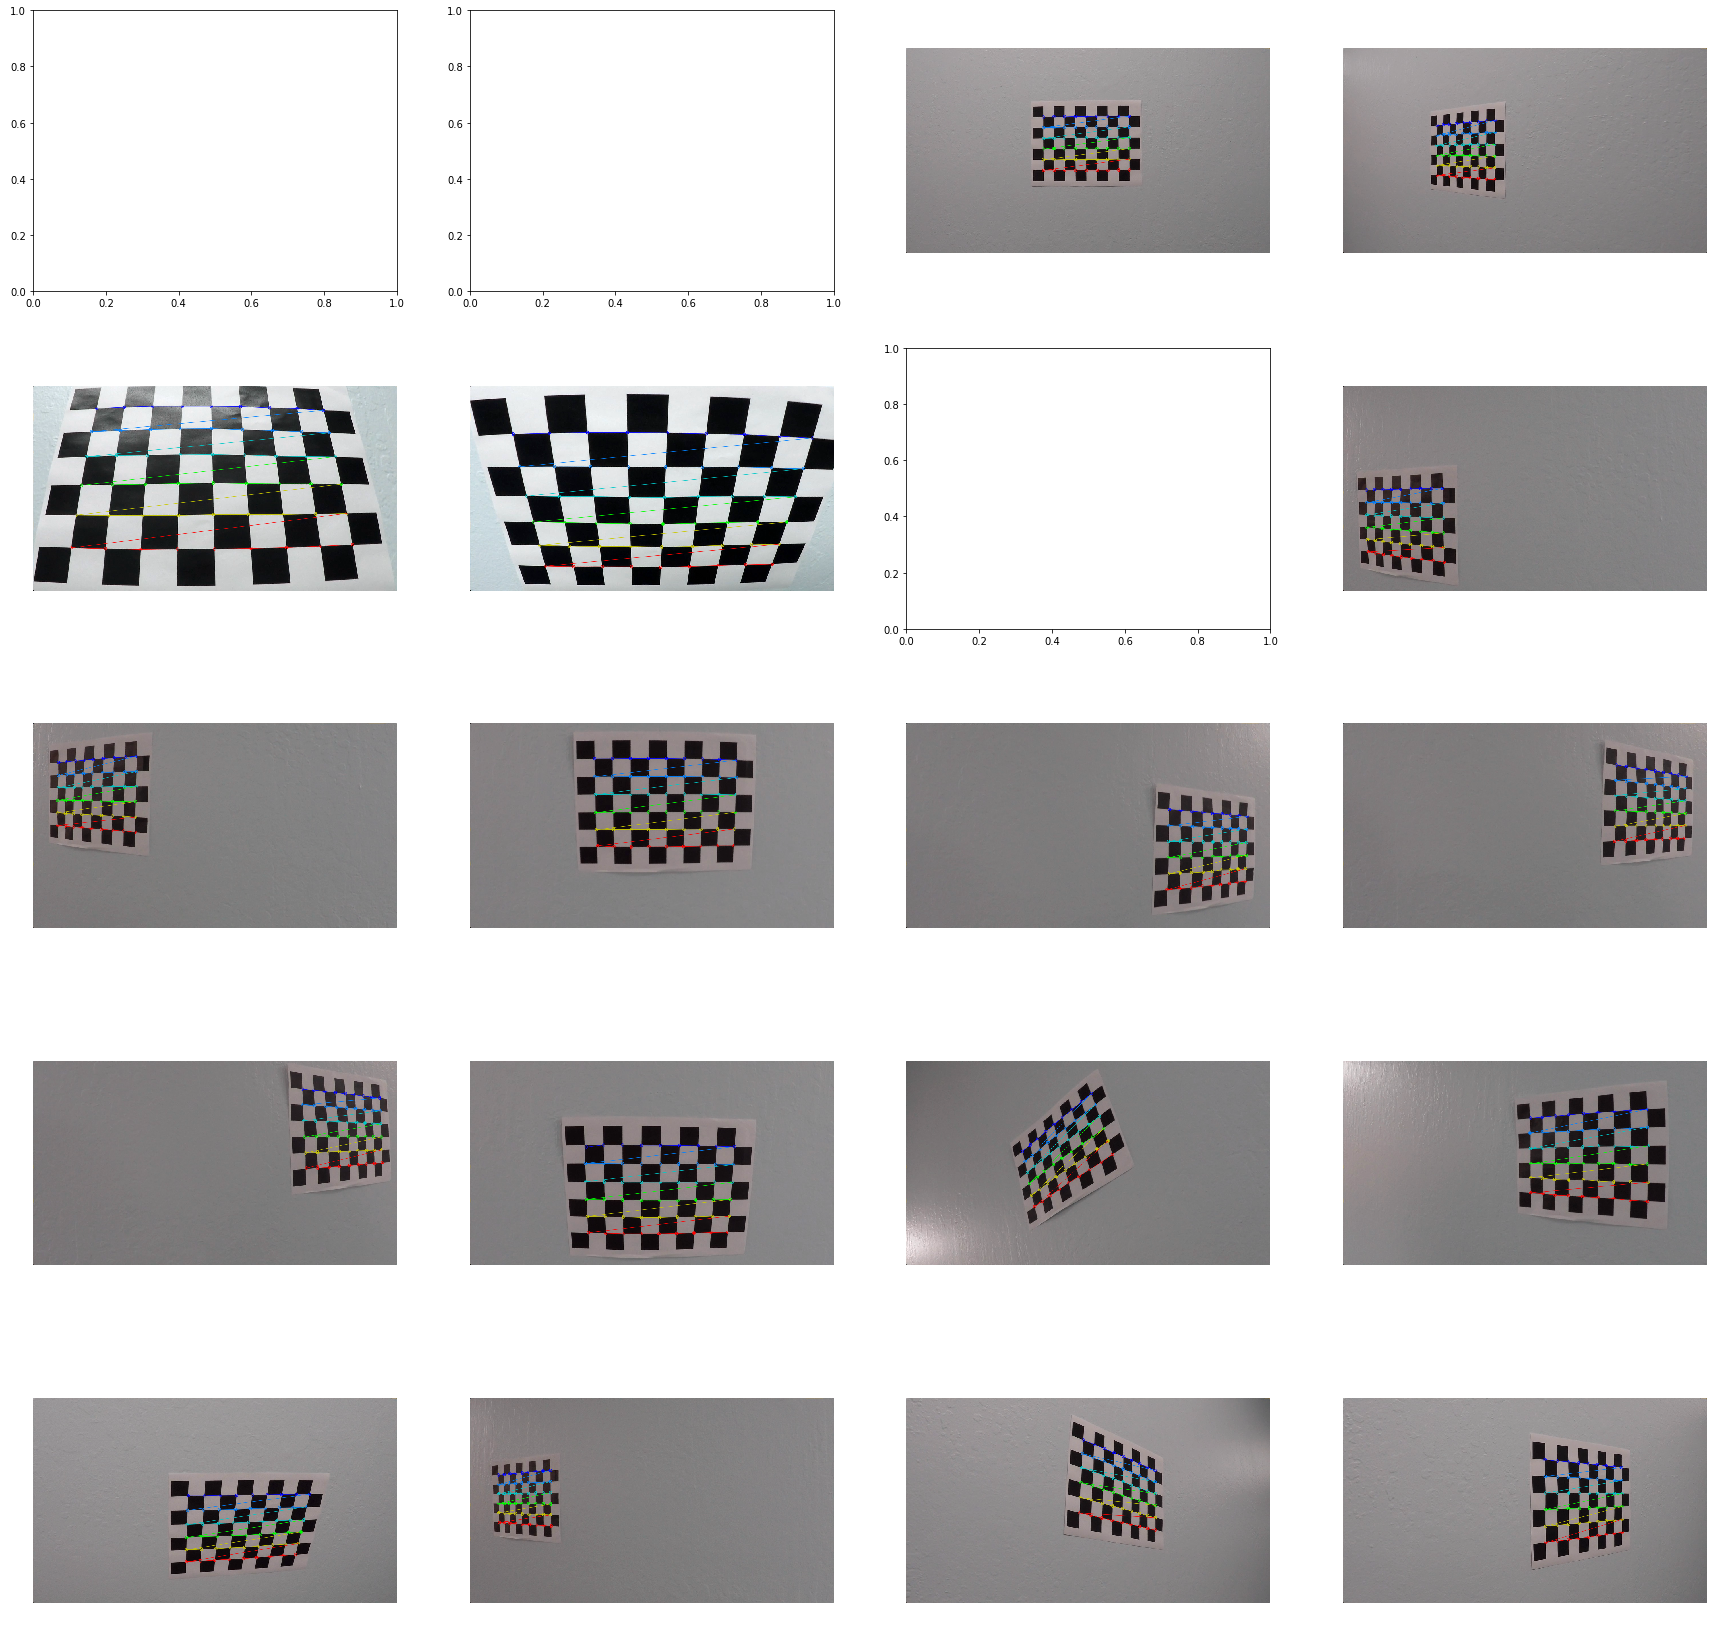

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from ipywidgets import interact, interactive, fixed

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axes = plt.subplots(5,4, figsize=(30, 30))
axes = axes.ravel()

# Step through the list and search for chessboard corners
for i,fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axes[i].axis('off')
        axes[i].imshow(img)

## Camera Calibration and Saving up the required parameters

In [2]:
img = cv2.imread('./camera_cal/calibration10.jpg')
#img_size = (img.shape[1], img.shape[0])

#Camera calibration, given object points, image points, and the shape of the grayscale image:

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

undist = cv2.undistort(img, mtx, dist, None, mtx)

# Saving the camera calibration parameters
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["rvecs"] = rvecs
dist_pickle["tvecs"] = tvecs
pickle.dump( dist_pickle, open( "CameraCalibration.p", "wb" ) )

# Making a method for the pipeline that will be made in later section
def undistort(img):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

## Undistorting images using above camera calibration

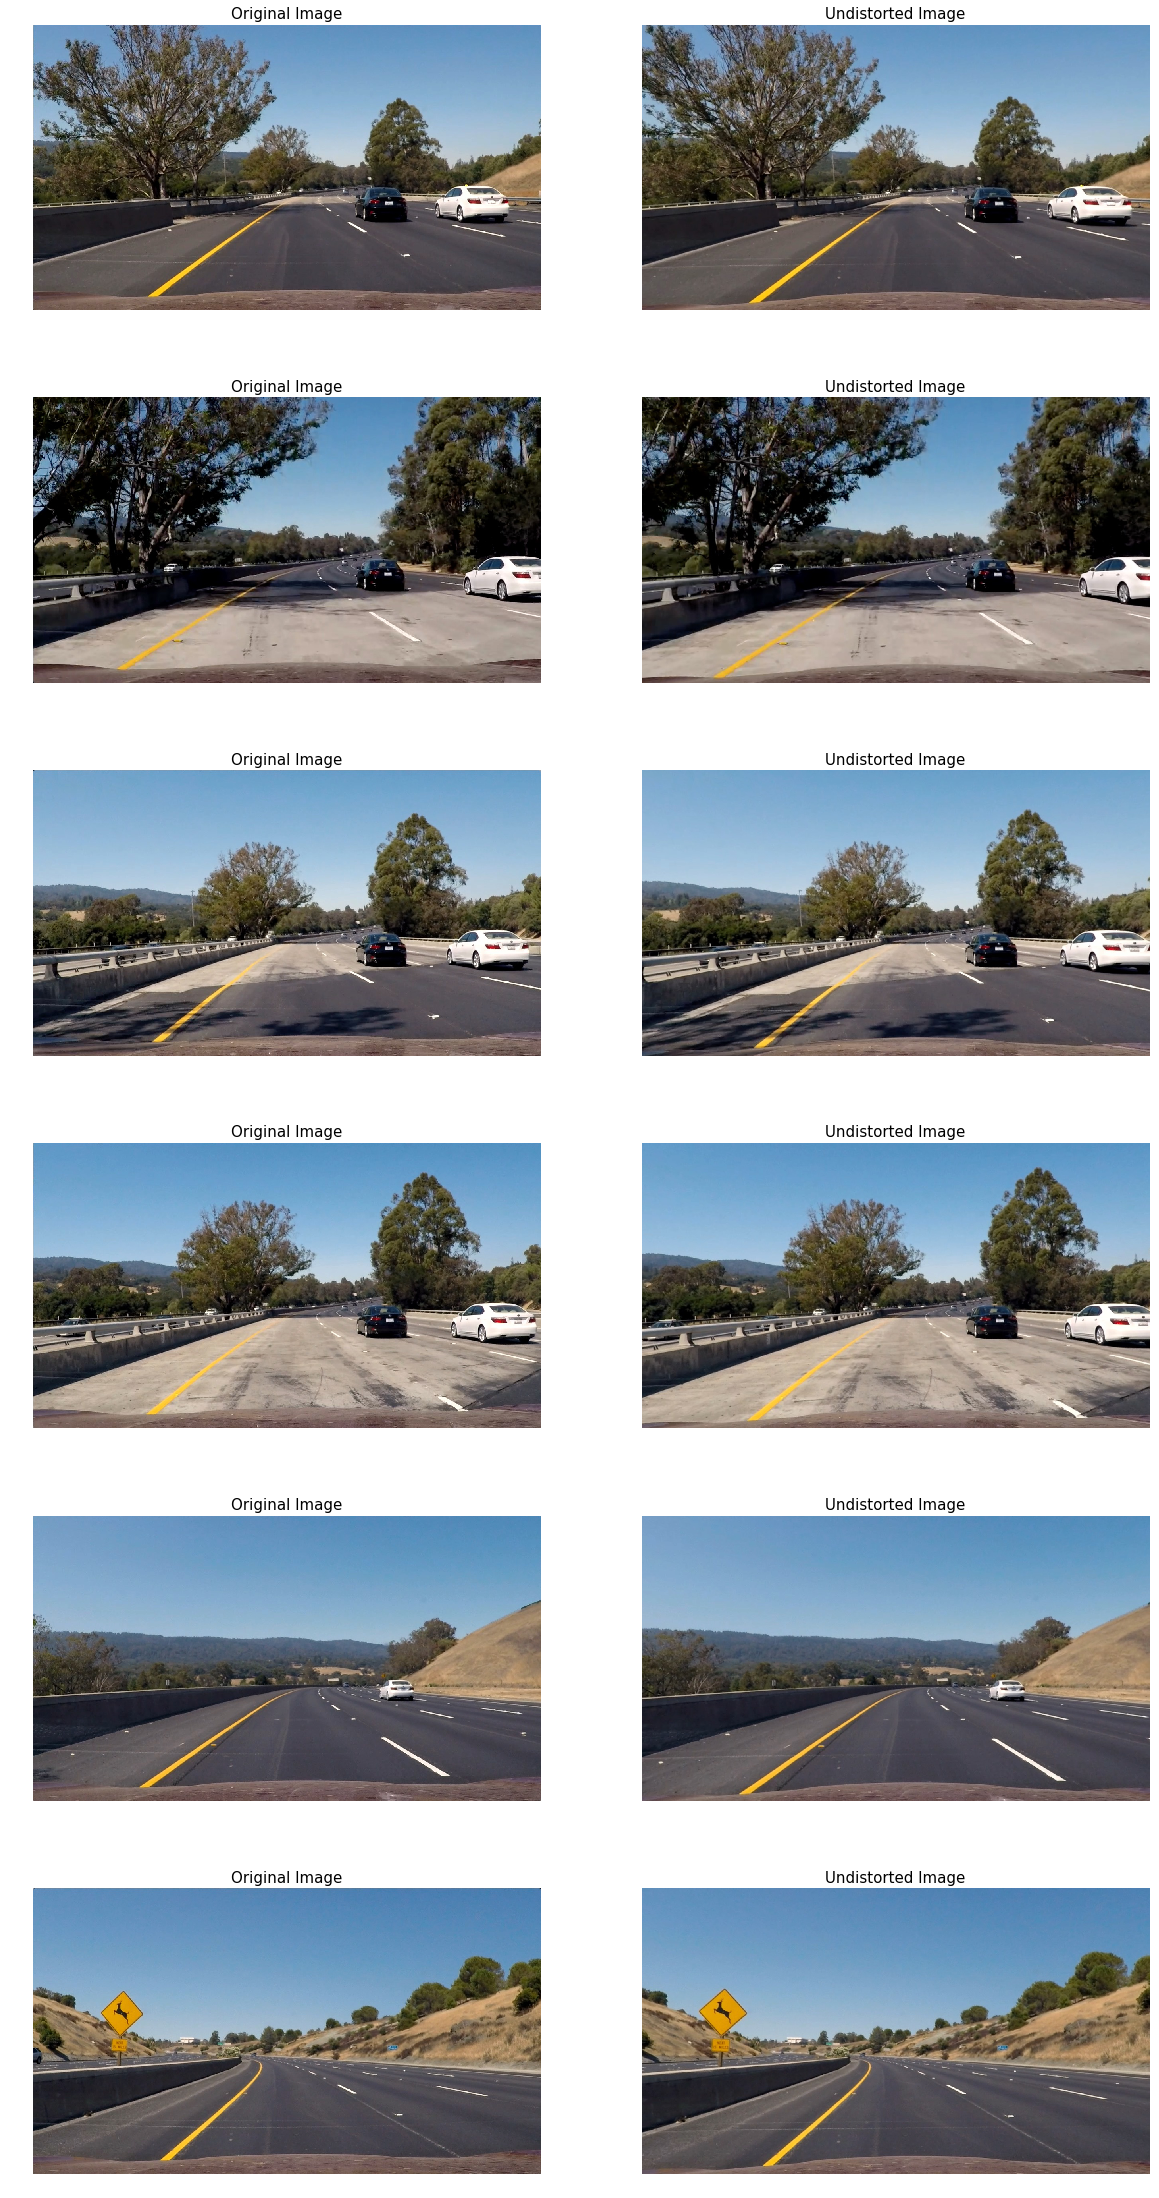

In [4]:

# list of test images
images = glob.glob('test_images/test*.jpg')

f, axarr = plt.subplots(6, 2, figsize=(20, 40))
undist_images = []

#Undistorting a test image:
for i, fname in enumerate(images):
    img = mpimg.imread(fname,0) 
    undist = cv2.undistort(img, mtx, dist, None, mtx) 
    undist_images.append(undist)
    axarr[i,0].axis('off')
    axarr[i,0].set_title('Original Image', fontsize=15)
    axarr[i,0].imshow(img)
    axarr[i,1].axis('off')
    axarr[i,1].set_title('Undistorted Image', fontsize=15)
    axarr[i,1].imshow(undist)

## Defining color space thresholding function

In [5]:
# HLS Color space
def hls_color_thresh(img, threshLow, threshHigh):
    imgHLS = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    binary_output = np.zeros((img.shape[0], img.shape[1]))
    binary_output[(imgHLS[:,:,0] >= threshLow[0]) & (imgHLS[:,:,0] <= threshHigh[0]) & (imgHLS[:,:,1] >= threshLow[1])  & (imgHLS[:,:,1] <= threshHigh[1])  & (imgHLS[:,:,2] >= threshLow[2]) & (imgHLS[:,:,2] <= threshHigh[2])] = 1
    return binary_output

## Applying Sobel transform and thresholding to undistorted image

In [6]:
#Sobel in x direction & Magnitude threshold
def sobel_x(img, sobel_kernel=3,min_thres = 20, max_thres =100):
    # Apply the following steps to img
    # 1) Convert to grayscale
    imghsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Take the gradient in x and y separately
    #Channels L and S from HLS
    sobelx1 = cv2.Sobel(imghsl[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobelx2 = cv2.Sobel(imghsl[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
        
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    scaled_sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))

    # 5) Create a binary mask where mag thresholds are met
    binary_outputx1 = np.zeros_like(scaled_sobelx1)
    binary_outputx1[(scaled_sobelx1 >= min_thres) & (scaled_sobelx1 <= max_thres)] = 1

    binary_outputx2 = np.zeros_like(scaled_sobelx2)
    binary_outputx2[(scaled_sobelx2 >= min_thres) & (scaled_sobelx2 <= max_thres)] = 1

    binary_output = np.zeros_like(scaled_sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    # 6) Return this mask as your binary_output image
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1


    # 6) Return this mask as your binary_output image
    return binary_output


#Direction threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

#Both Magnitude and direction threshold
def mag_dir_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), dir_thresh=(0,np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1,0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(img, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    #Calc angle
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1]) & (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1]) ] = 1


    # 6) Return this mask as binary_output image
    return binary_output

## Examples of gradient and color thresholding

Examples of magnitude and direction thresholds


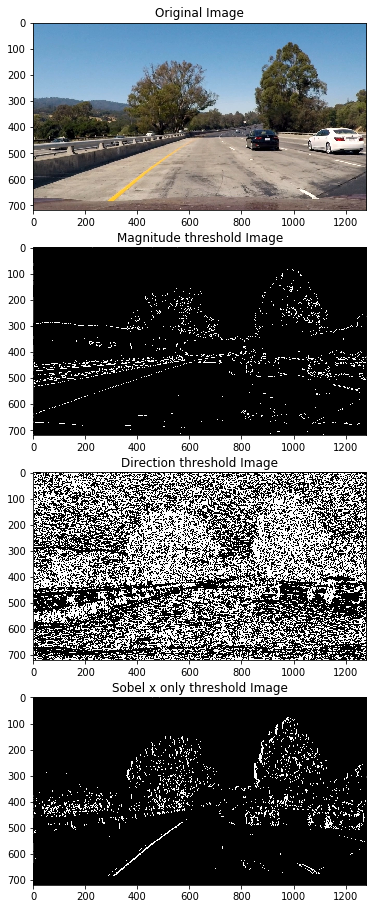

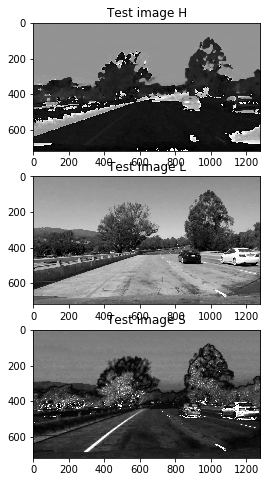

In [9]:
#Examples of magnitude and direction thresholds
plt.figure(figsize=(10,8))

img = cv2.imread("test_images/test1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

magThr =mag_thresh(imgRGB, 3, (50, 100))

dirThr =dir_threshold(imgRGB, 9,(np.pi/240/90, np.pi/2*60/90))

#Sobel x only
imgThr = sobel_x(imgRGB,9,80,220) #Sobel x

print("Examples of magnitude and direction thresholds")
plt.figure(figsize=(40,20))

plt.subplot(5,1,1)
plt.title('Original Image')
fig =plt.imshow(imgRGB)

plt.subplot(5,1,2)
plt.title('Magnitude threshold Image')
fig =plt.imshow(magThr,cmap = 'gray')

plt.subplot(5,1,3)
plt.title('Direction threshold Image')
fig =plt.imshow(dirThr,cmap = 'gray')

plt.subplot(5,1,4)
plt.title('Sobel x only threshold Image')
fig =plt.imshow(imgThr,cmap = 'gray')

# on test images

img = cv2.imread("test_images/test1.jpg")
imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.title('Test image H')
fig =plt.imshow(imgHLS[:,:,0],cmap='gray')
plt.subplot(3,1,2)
plt.title('Test Image L')
fig =plt.imshow(imgHLS[:,:,1],cmap='gray')
plt.subplot(3,1,3)
plt.title('Test image S')
fig =plt.imshow(imgHLS[:,:,2],cmap='gray')

## Perspective transform and warped image

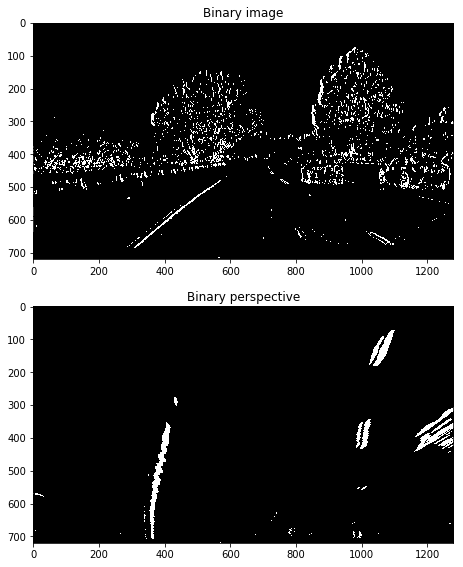

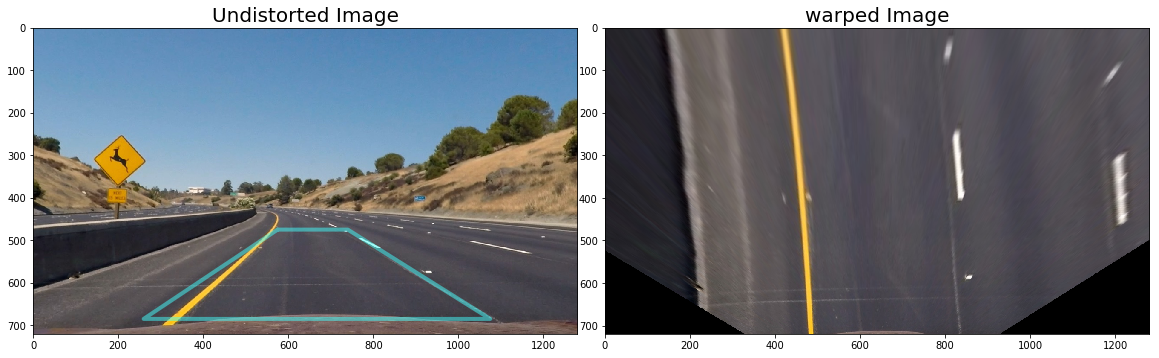

In [11]:
#Perspective transfomation

src = np.float32([[585, 450], [204, 720], [1126, 720], [695, 450]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

M_persp = cv2.getPerspectiveTransform(src, dst)
Minv_persp = cv2.getPerspectiveTransform(dst, src)

img_size = (imgThr.shape[1], imgThr.shape[0])
binary_warped = cv2.warpPerspective(imgThr, M_persp, img_size, flags=cv2.INTER_LINEAR)


plt.figure(figsize=(30,20))

plt.subplot(4,1,1)
plt.title('Binary image')
fig =plt.imshow(imgThr, cmap='gray')

plt.subplot(4,1,2)
plt.title('Binary perspective')
fig =plt.imshow(binary_warped, cmap='gray')

# Warp image

def warp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
    

h,w = undist_images[5].shape[:2]

# # define source and destination points for transform for test3.jpg
src = np.float32([(575,475),
                  (740,475), 
                  (260,685), 
                  (1075,685)])

dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

undist_images_warp, M, Minv = warp(undist_images[5], src, dst)

# Visualize warp
f, (axes1, axes2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
axes1.imshow(undist_images[5])

x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

axes1.plot(x,y, color='#44ffff', alpha=0.5, linewidth=4, solid_capstyle='round', zorder=2)
axes1.imshow(undist_images[5])
axes1.set_ylim([h,0])
axes1.set_xlim([0,w])
axes1.set_title('Undistorted Image', fontsize=20)

axes2.imshow(undist_images_warp)
axes2.set_title('warped Image', fontsize=20)

## Fit the lines found onto a polynomial

In [14]:
def fitlines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return left_fit, right_fit,out_img

(720, 1280, 3)
255.0


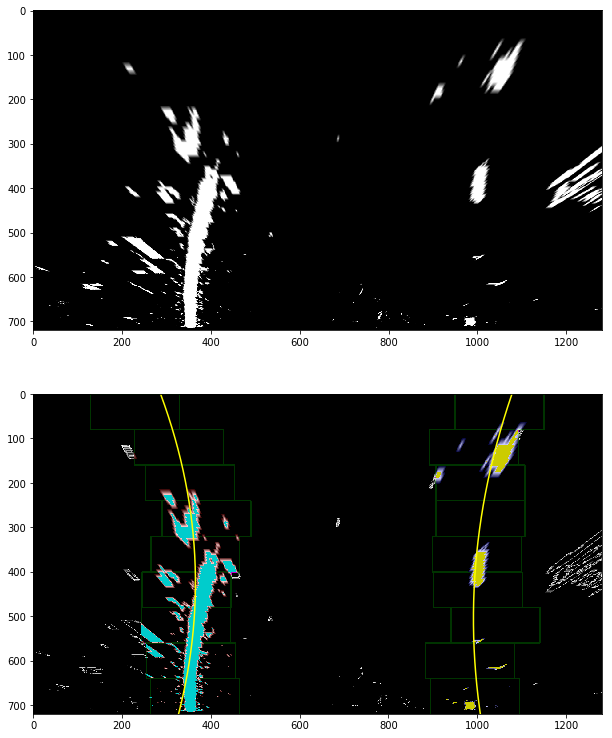

In [15]:
#Visualization of lines fitted
img = cv2.imread("test_images/test1.jpg")
#img = cv2.imread("test_images/straight_lines2.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_undist = cv2.undistort(imgRGB, mtx, dist, None, mtx)

#2.Magnitude Threshold
#Threshold color    
yellow_low = np.array([0,100,100])
yellow_high = np.array([50,255,255])
white_low = np.array([18,0,180])
white_high = np.array([255,80,255])
global ref_left 
global ref_right
global left_fit
global right_fit

imgThres_yellow = hls_color_thresh(img_undist,yellow_low,yellow_high)
imgThres_white = hls_color_thresh(img_undist,white_low,white_high)
imgThr_sobelx = sobel_x(img_undist,9,80,220) #Sobel x only

img_mag_thr =np.zeros_like(imgThres_yellow)
img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1)] =1


#3. Birds-eye
#Perspective array from before
img_size = (img_mag_thr.shape[1], img_mag_thr.shape[0])
binary_warped = cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)

left_fit, right_fit,out_img = fitlines(binary_warped)


print(out_img.shape)
print(np.max(out_img))


ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    

plt.figure(figsize=(30,20))
plt.subplot(3,1,1)
plt.imshow(binary_warped, cmap='gray')

plt.subplot(3,1,2)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.subplot(3,1,2)
binary_warped2 = np.zeros((720, 1280,3))
binary_warped2[:,:,0] = binary_warped
binary_warped2[:,:,1] = binary_warped
binary_warped2[:,:,2] = binary_warped
plt.imshow(out_img)
result = cv2.addWeighted(binary_warped2, .8, out_img, .8, 0)
plt.imshow(result)

In [16]:

def fit_continuous(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_updated =[]
    else:
        left_fit_updated = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_updated =[]
    else:
        right_fit_updated = np.polyfit(righty, rightx, 2)
        
    return  left_fit_updated, right_fit_updated

## Calculate curvature

In [17]:
def curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    # from estimate of US lane regulations (approx)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad, center

## Draw fitted lane on image

In [18]:

def drawLine(undist, warped,left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    #print(left_fitx)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_persp, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return(result, color_warp)

## Pipeline for image

In [19]:
global counter
counter=0
ref_left =np.array([-0.0001,0,400])
ref_right=np.array([-0.0001,0,1000])   
left_fit =np.array([-0.0001,0,400])
right_fit=np.array([-0.0001,0,1000])   

def process_image(image):
    #1. Camera correction
    #Calibration arrays pre-calculated
    img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    global counter
    
    #2.Magnitude Threshold
    #Threshold color    
    yellow_low = np.array([0,100,100])
    yellow_high = np.array([50,255,255])
    white_low = np.array([18,0,180])
    white_high = np.array([255,80,255])
    global ref_left 
    global ref_right
    global left_fit
    global right_fit

    imgThres_yellow = hls_color_thresh(img_undist,yellow_low,yellow_high)
    imgThres_white = hls_color_thresh(img_undist,white_low,white_high)
    imgThr_sobelx = sobel_x(img_undist,9,80,220) #Sobel x

    img_mag_thr =np.zeros_like(imgThres_yellow)
    #imgThresColor[(imgThres_yellow==1) | (imgThres_white==1)] =1
    img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
        
    #3. Birds-eye
    #Perspective array pre-calculated
    img_size = (img_mag_thr.shape[1], img_mag_thr.shape[0])
    binary_warped = cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)
    
    #4. Detect lanes and return fit curves
    
    if counter==0:
        left_fit, right_fit,out_imgfit = fitlines(binary_warped)
    else:
        left_fit, right_fit = fit_continuous(left_fit, right_fit, binary_warped)
    
    status_sanity, d0, d1 =sanity_check(left_fit, right_fit, 0, .55)  
    #Calc curvature and center
    if status_sanity  == True:        
        #Save as last reliable fit
        ref_left, ref_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = ref_left, ref_right
        
    left_curv, right_curv, center_off = curvature(left_fit, right_fit, binary_warped)

    #Warp back to original and merge with image    
    img_out, img_birds = drawLine(img_undist, binary_warped,left_fit, right_fit)

    
    #Write curvature and center in image
    TextL = "Left curv: " + str(int(left_curv)) + " m"
    TextR = "Right curv: " + str(int(right_curv))+ " m"
    TextC = "Center offset: " + str(round( center_off,2)) + "m"

    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX


    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(200,255,155), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(200,255,155), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(200,255,155), thickness,  lineType = cv2.LINE_AA)
   
    return img_out

## Sanity check as instructed in rubric

In [23]:
def sanity_check(left_fit, right_fit, minSlope, maxSlope):
    #Performs a sanity check on the lanes
    #Check 1: check if left and right fits exists
    #Check 2: Calculates the tangent between left and right in two points, and check if it is in a reasonable threshold
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
        d0=0
        d1=0
        #Previous fitlines routine returns empty list to them if not finds
    else:
        #Difference of slope
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)

        
        if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope:
            status = True
        else:
            status = False
            
    return(status, d0, d1)

1201.763849 m 2080.02000126 m


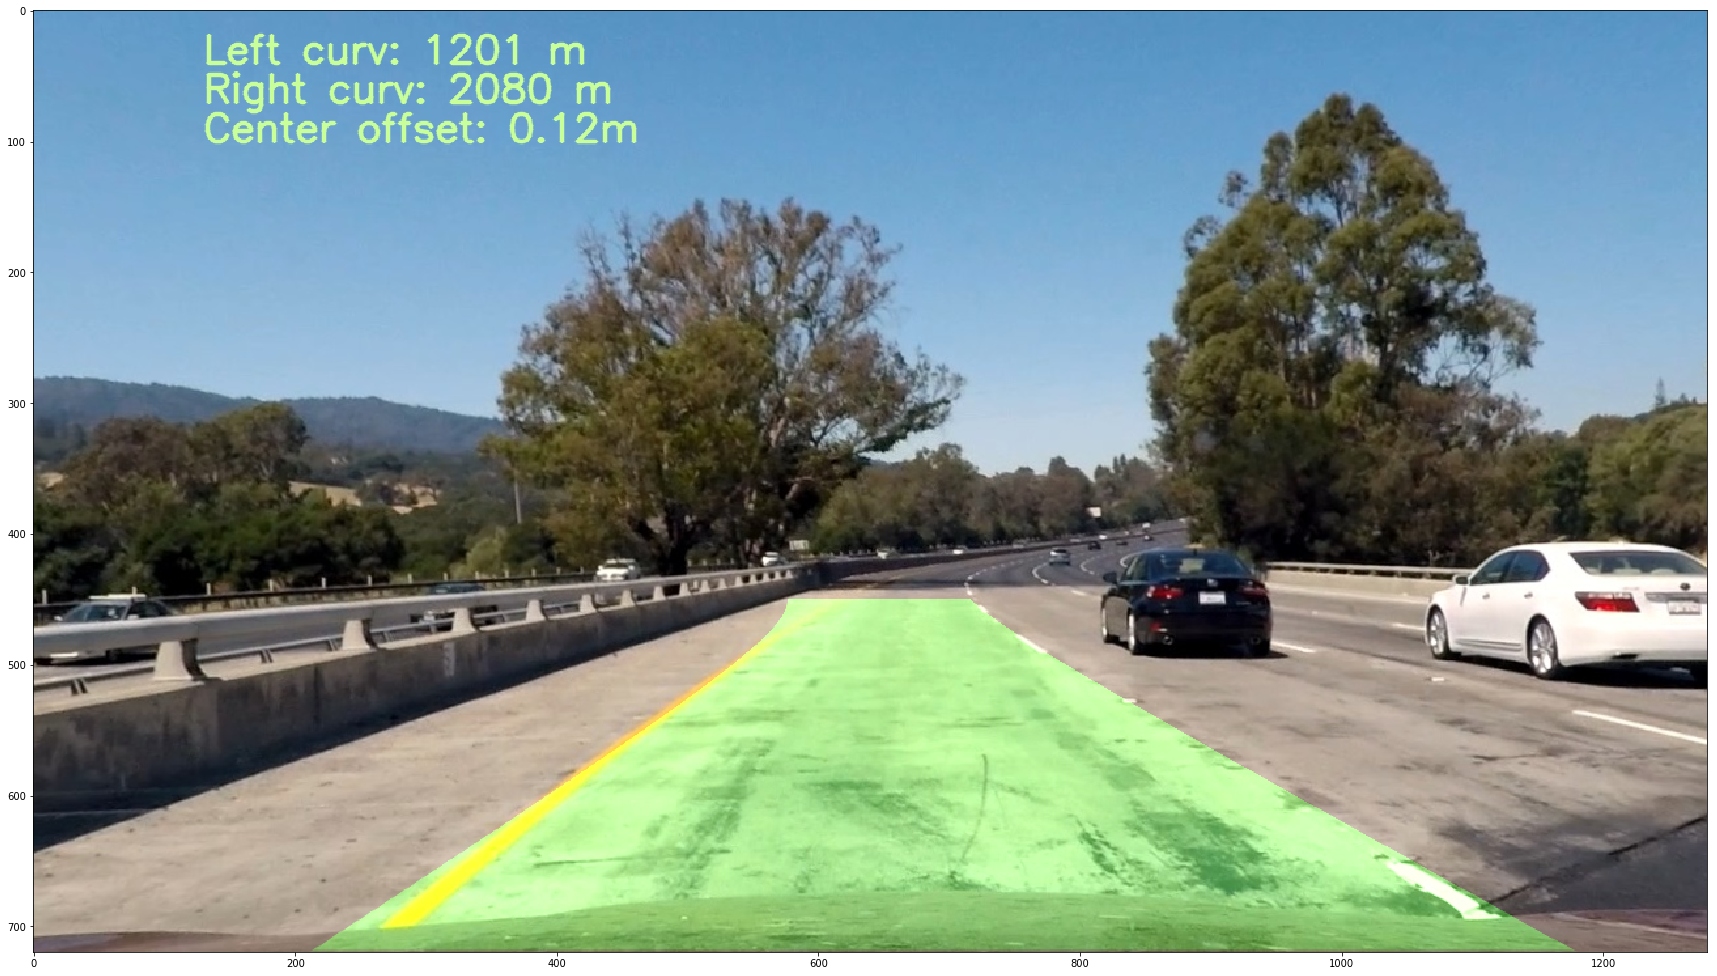

In [24]:
img = cv2.imread("test_images/test1.jpg")
#img = cv2.imread("test_images/straight_lines1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2= process_image(imgRGB)

plt.figure(figsize=(10,15))
#plt.figure(figsize=(5,10))

  
plt.figure(figsize=(30,20))
plt.imshow(img2)

## Video setup

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0360448/28549024 bytes (1.31163264/28549024 bytes (4.1%1933312/28549024 bytes (6.8%2924544/28549024 bytes (10.23538944/28549024 bytes (12.44440064/28549024 bytes (15.65226496/28549024 bytes (18.36242304/28549024 bytes (21.97061504/28549024 bytes (24.77634944/28549024 bytes (26.78388608/28549024 bytes (29.49216000/28549024 bytes (32.39805824/28549024 bytes (34.310633216/28549024 bytes (37.2%11362304/28549024 bytes (39.8%11837440/28549024 bytes (41.5%12427264/28549024 bytes (43.5%13230080/28549024 bytes (46.3%13967360/28549024 bytes (48.9%14655488/28549024 bytes (51.3%15507456/28549024 bytes (54.3%16343040/28549024 bytes (57.2%16982016/28549024 bytes (59.5%17752064/28549024 bytes (62.2%18096128/28549024 bytes (63.4%18595840/28549024 bytes (65.1%19529728/28549024 bytes (

In [26]:
#Create video file pipeline
counter=0
output = 'out_test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image)
%time out_clip.write_videofile(output, audio=False)
print(counter)

1581.63670627 m 3163.43672394 m
[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


  0%|          | 1/1261 [00:00<03:59,  5.26it/s]

1581.63670627 m 3163.43672394 m


  0%|          | 2/1261 [00:00<04:21,  4.81it/s]

1580.22143591 m 2519.95704358 m
1585.70947426 m 2610.38037015 m


  0%|          | 5/1261 [00:00<03:54,  5.36it/s]

1608.01725201 m 2341.24933763 m
1653.56197867 m 2294.09627646 m


  1%|          | 7/1261 [00:01<03:39,  5.72it/s]

1670.10721714 m 2057.49485089 m
1756.27380195 m 2176.67549227 m


  1%|          | 8/1261 [00:01<03:46,  5.52it/s]

1748.10085578 m 2380.88907082 m


  1%|          | 9/1261 [00:01<04:24,  4.74it/s]

1835.32812777 m 2486.31716152 m
1837.78418109 m 3046.39980261 m


  1%|          | 12/1261 [00:02<03:53,  5.35it/s]

1856.08437483 m 3247.82820346 m
1968.87214914 m 3032.03879103 m


  1%|          | 14/1261 [00:02<04:12,  4.95it/s]

1988.55892335 m 4003.30688974 m
1952.35513247 m 3507.40394904 m


  1%|          | 15/1261 [00:02<04:29,  4.63it/s]

1875.97765523 m 2658.33441251 m
1776.42500681 m 2425.82507826 m


  1%|▏         | 18/1261 [00:03<03:54,  5.31it/s]

1783.69385786 m 2326.01788691 m
1794.2421544 m 2240.01003077 m


  2%|▏         | 19/1261 [00:03<04:03,  5.11it/s]

1814.59290103 m 2145.82356844 m


  2%|▏         | 20/1261 [00:03<04:12,  4.92it/s]

1816.62899836 m 2066.04416313 m


  2%|▏         | 21/1261 [00:04<04:22,  4.72it/s]

1889.18798736 m 1824.01537752 m


  2%|▏         | 23/1261 [00:04<04:16,  4.83it/s]

1915.60305688 m 1834.70706639 m
1963.79973027 m 1864.37427188 m


  2%|▏         | 24/1261 [00:04<04:21,  4.73it/s]

1741.36444027 m 2301.13154963 m


  2%|▏         | 25/1261 [00:05<04:23,  4.70it/s]

1707.85636286 m 2599.82162859 m
1737.67545117 m 2695.2957822 m


  2%|▏         | 27/1261 [00:05<04:02,  5.09it/s]

1665.12255346 m 2888.47242303 m


  2%|▏         | 28/1261 [00:05<04:25,  4.64it/s]

1696.17037955 m 2931.64384374 m
1606.87915857 m 2630.2553467 m


  2%|▏         | 31/1261 [00:06<03:48,  5.37it/s]

1508.98730555 m 2320.18267298 m
1465.84667514 m 1972.35005932 m


  3%|▎         | 32/1261 [00:06<04:15,  4.81it/s]

1415.52981592 m 1846.87503351 m
1434.36308912 m 1672.39012061 m


  3%|▎         | 34/1261 [00:06<03:59,  5.12it/s]

1419.00285185 m 1785.71921297 m
1418.09647798 m 1975.48774347 m


  3%|▎         | 37/1261 [00:07<03:52,  5.27it/s]

1443.19433515 m 2069.22841734 m
1450.93885253 m 2073.42960322 m


  3%|▎         | 38/1261 [00:07<03:50,  5.30it/s]

1429.85087727 m 1925.87762145 m
1416.48795966

  3%|▎         | 39/1261 [00:07<04:06,  4.96it/s]

 m 1865.14618676 m


  3%|▎         | 40/1261 [00:08<04:15,  4.77it/s]

1432.30161175 m 1883.33820013 m
1446.82213262 m 1882.87994026 m


  3%|▎         | 42/1261 [00:08<04:10,  4.87it/s]

1497.53014628 m 1950.64398633 m


  3%|▎         | 43/1261 [00:08<04:38,  4.38it/s]

1547.09729563 m 1977.63135986 m
1615.94490156 m 1915.13366631 m


  4%|▎         | 46/1261 [00:09<04:02,  5.02it/s]

1690.1676388 m 1888.61908425 m
1712.05635374 m 1764.94228981 m


  4%|▎         | 47/1261 [00:09<03:57,  5.11it/s]

1762.39753787 m 1834.5809387 m


  4%|▍         | 48/1261 [00:09<04:27,  4.54it/s]

1783.49685255 m 2134.52070073 m


  4%|▍         | 49/1261 [00:09<04:27,  4.53it/s]

1868.31654314 m 2271.32724383 m


  4%|▍         | 50/1261 [00:10<04:30,  4.48it/s]

1870.62257718 m 2308.12109003 m


  4%|▍         | 51/1261 [00:10<04:55,  4.10it/s]

1918.67211926 m 2352.75544886 m


  4%|▍         | 52/1261 [00:10<05:09,  3.91it/s]

1879.80175663 m 2417.09310005 m


  4%|▍         | 53/1261 [00:10<04:58,  4.04it/s]

1845.51203858 m 2235.27083598 m
1931.61605556 m 2180.99975707 m


  4%|▍         | 55/1261 [00:11<04:25,  4.54it/s]

1962.27881628 m 2172.49464057 m


  4%|▍         | 56/1261 [00:11<04:28,  4.48it/s]

1968.34523931 m 2260.90351191 m


  5%|▍         | 57/1261 [00:11<04:43,  4.25it/s]

1938.91232797 m 2268.5812911 m
2016.71286786 m 2368.21196733 m


  5%|▍         | 59/1261 [00:12<04:16,  4.69it/s]

1916.09683813 m 3216.07834513 m


  5%|▍         | 60/1261 [00:12<04:20,  4.62it/s]

1841.15781149 m 2700.63404553 m


  5%|▍         | 62/1261 [00:12<04:07,  4.85it/s]

1842.41077935 m 2502.32124636 m
1786.46844218 m 2086.6338221 m


  5%|▍         | 63/1261 [00:13<03:57,  5.04it/s]

1787.19647398 m 2004.85595914 m
1729.84894399 m 1959.01329054

  5%|▌         | 64/1261 [00:13<04:01,  4.96it/s]

 m
1755.45494964 m 1973.77904408 m


  5%|▌         | 66/1261 [00:13<04:16,  4.65it/s]

1732.35679396 m 2130.77681805 m


  5%|▌         | 67/1261 [00:13<04:26,  4.48it/s]

1691.51414247 m 2148.82915743 m


  5%|▌         | 68/1261 [00:14<04:34,  4.34it/s]

1744.95260427 m 2171.0129885 m


  5%|▌         | 69/1261 [00:14<05:01,  3.95it/s]

1691.77819109 m 2216.52340702 m
1794.09023114 m 2090.39431639 m


  6%|▌         | 72/1261 [00:15<04:01,  4.93it/s]

1756.92557807 m 1957.35041299 m
1844.11241106 m 2017.2170272 m


  6%|▌         | 73/1261 [00:15<04:08,  4.78it/s]

1957.79763556 m 1890.92306751 m


  6%|▌         | 74/1261 [00:15<04:15,  4.64it/s]

1986.29313193 m 1755.2059329 m


  6%|▌         | 75/1261 [00:15<04:52,  4.05it/s]

2073.54284708 m 1987.8205329 m


  6%|▌         | 76/1261 [00:16<06:03,  3.26it/s]

2092.75836295 m 1887.99040797 m


  6%|▌         | 77/1261 [00:16<07:00,  2.82it/s]

2237.96472267 m 1994.69063262 m


  6%|▌         | 78/1261 [00:17<07:32,  2.61it/s]

2345.99585116 m 2302.56783691 m


  6%|▋         | 79/1261 [00:17<06:34,  3.00it/s]

2370.04612156 m 2012.27796095 m


  6%|▋         | 80/1261 [00:17<06:46,  2.90it/s]

2238.05086033 m 2044.61918518 m


  6%|▋         | 81/1261 [00:18<06:41,  2.94it/s]

2099.91437581 m 1927.39503845 m


  7%|▋         | 82/1261 [00:18<06:09,  3.19it/s]

2076.19425035 m 1918.21574558 m
2048.4063992 m 1994.13266939 m


  7%|▋         | 85/1261 [00:18<04:35,  4.27it/s]

2213.46385417 m 1782.07409939 m
2021.21323062 m 1982.40897338 m


  7%|▋         | 86/1261 [00:19<04:27,  4.39it/s]

1936.81272053 m 2241.57226355 m


  7%|▋         | 87/1261 [00:19<04:38,  4.21it/s]

1760.92431698 m 2791.78723694 m


  7%|▋         | 89/1261 [00:19<04:13,  4.63it/s]

1619.40153506 m 2667.85463113 m
1532.97666497 m 2185.17189498 m


  7%|▋         | 90/1261 [00:20<04:03,  4.81it/s]

1445.09102202 m 1961.63429307 m
1446.93231989 m

  7%|▋         | 91/1261 [00:20<04:05,  4.77it/s]

 1982.78406396 m
1470.21516567 m 1934.45091714 m


  7%|▋         | 94/1261 [00:20<03:45,  5.18it/s]

1409.8478867 m 1982.24340743 m
1432.59997289 m 2117.76518098 m


  8%|▊         | 95/1261 [00:20<03:43,  5.23it/s]

1460.05824378 m 2035.01532288 m
1494.83453214 m 1918.88579393 m


  8%|▊         | 97/1261 [00:21<03:46,  5.14it/s]

1519.13449394 m 1853.26740119 m
1551.5998795 m 2283.77106947 m


  8%|▊         | 99/1261 [00:21<03:46,  5.12it/s]

1520.19468075 m 2255.41246228 m


  8%|▊         | 101/1261 [00:22<03:48,  5.07it/s]

1532.99491486 m 2294.90831411 m
1497.82158433 m 2029.00864152 m


  8%|▊         | 102/1261 [00:22<03:41,  5.22it/s]

1492.61580228 m 1755.21276626 m
1495.58776879 m 1806.14339067 m


  8%|▊         | 104/1261 [00:22<03:53,  4.96it/s]

1456.67746473 m 1815.66723556 m


  8%|▊         | 105/1261 [00:22<03:58,  4.84it/s]

1485.59122476 m 1891.79844794 m
1530.58378183 m 1854.20238845 m


  8%|▊         | 107/1261 [00:23<03:48,  5.05it/s]

1561.85762811 m 1813.17691843 m


  9%|▊         | 108/1261 [00:23<03:59,  4.81it/s]

1511.76612119 m 1675.03169933 m


  9%|▊         | 109/1261 [00:23<04:11,  4.58it/s]

1477.58081296 m 1588.91419558 m
1472.42002841 m 1746.74337296 m


  9%|▉         | 111/1261 [00:24<03:52,  4.94it/s]

1430.88866165 m 1963.67882466 m
1522.03792911 m 1929.64873629 m


  9%|▉         | 113/1261 [00:24<03:52,  4.93it/s]

1487.94733291 m 1890.76402682 m
1468.01935981 m 1983.71633739 m


  9%|▉         | 115/1261 [00:24<03:46,  5.05it/s]

1414.10577693 m 1746.45771966 m


  9%|▉         | 116/1261 [00:25<03:57,  4.82it/s]

1400.69650161 m 1745.64257333 m


  9%|▉         | 117/1261 [00:25<04:05,  4.67it/s]

1421.88187515 m 1714.55140296 m


  9%|▉         | 118/1261 [00:25<04:00,  4.76it/s]

1419.72742264 m 1744.38908953 m


  9%|▉         | 119/1261 [00:25<03:48,  5.01it/s]

1434.96341133 m 1799.6337246 m


 10%|▉         | 120/1261 [00:26<03:55,  4.85it/s]

1419.62018528 m 1899.54994591 m


 10%|▉         | 121/1261 [00:26<03:57,  4.79it/s]

1462.98286131 m 1979.06560243 m


 10%|▉         | 122/1261 [00:26<03:56,  4.83it/s]

1476.42464504 m 2019.06097711 m


 10%|▉         | 123/1261 [00:26<04:07,  4.60it/s]

1463.79594123 m 1900.98824528 m


 10%|▉         | 125/1261 [00:27<03:45,  5.03it/s]

1474.28006423 m 1885.70715904 m
1481.50160225 m 1802.67166762 m


 10%|█         | 127/1261 [00:27<03:33,  5.31it/s]

1553.65279104 m 1892.93693686 m
1548.60061575 m 1853.52287394 m


 10%|█         | 129/1261 [00:27<03:30,  5.37it/s]

1614.13332904 m 1883.12705552 m
1554.05015265 m 1972.54742782 m


 10%|█         | 130/1261 [00:27<03:30,  5.38it/s]

1574.5944102 m 2009.69264474 m
1621.34668267 m 2162.51016662 m


 10%|█         | 132/1261 [00:28<03:49,  4.92it/s]

1601.8826404 m 2200.71403149 m
1617.65650761 m 2149.20385579 m


 11%|█         | 134/1261 [00:28<03:42,  5.06it/s]

1608.49496316 m 2485.97031728 m
1703.43603544 m 2825.64106625 m


 11%|█         | 136/1261 [00:29<03:46,  4.96it/s]

1715.95421729 m 2397.73293185 m
1793.79716101 m 2649.41784818 m


 11%|█         | 138/1261 [00:29<03:34,  5.23it/s]

1835.08106573 m 2505.15528434 m
1900.51384783 m 2879.3722109 m


 11%|█         | 141/1261 [00:30<03:27,  5.41it/s]

1942.04422115 m 2768.15031645 m
1854.58898822 m 2346.5562358 m


 11%|█▏        | 142/1261 [00:30<03:28,  5.38it/s]

1864.98232985 m 2305.1797836 m
1803.40746111 m 2018.59309789 m


 11%|█▏        | 144/1261 [00:30<03:38,  5.10it/s]

1792.09197367 m 2113.99947936 m
1779.30733151 m 2075.37107673 m


 12%|█▏        | 146/1261 [00:31<03:30,  5.31it/s]

1683.88449817 m 2159.01002023 m
1754.70080764 m 2227.37052317 m


 12%|█▏        | 148/1261 [00:31<03:38,  5.10it/s]

1597.7958801 m 2081.15592681 m
1559.60693876 m 1864.74643944 m


 12%|█▏        | 150/1261 [00:31<03:28,  5.33it/s]

1638.67056123 m 2023.8727773 m
1676.47434104 m 2173.10392743 m


 12%|█▏        | 152/1261 [00:32<03:38,  5.08it/s]

1701.83414194 m 1905.27887373 m


 12%|█▏        | 153/1261 [00:32<05:07,  3.60it/s]

1642.70830471 m 1910.00458428 m


 12%|█▏        | 154/1261 [00:33<05:07,  3.60it/s]

1713.02650068 m 1966.89827002 m


 12%|█▏        | 155/1261 [00:33<05:21,  3.44it/s]

1733.78514153 m 2028.1931237 m


 12%|█▏        | 156/1261 [00:33<05:22,  3.43it/s]

1662.10229058 m 2027.30857821 m


 12%|█▏        | 157/1261 [00:33<05:27,  3.37it/s]

1682.0290195 m 2143.77152481 m


 13%|█▎        | 158/1261 [00:34<05:09,  3.56it/s]

1611.22824034 m 2135.49555914 m


 13%|█▎        | 159/1261 [00:34<05:21,  3.43it/s]

1669.06903807 m 2211.43702878 m


 13%|█▎        | 160/1261 [00:34<05:14,  3.50it/s]

1590.70351891 m 2299.01480034 m


 13%|█▎        | 161/1261 [00:35<05:13,  3.51it/s]

1629.91579168 m 2385.63684711 m


 13%|█▎        | 162/1261 [00:35<05:29,  3.33it/s]

1631.13049042 m 2409.83981828 m


 13%|█▎        | 163/1261 [00:35<05:05,  3.59it/s]

1651.88328016 m 2372.29014583 m


 13%|█▎        | 164/1261 [00:35<05:24,  3.38it/s]

1663.95082465 m 1934.82219682 m


 13%|█▎        | 165/1261 [00:36<05:23,  3.38it/s]

1592.04619594 m 1779.29780051 m


 13%|█▎        | 166/1261 [00:36<05:11,  3.52it/s]

1580.37684572 m 1775.29292795 m
1525.95594595 m 1902.97158026 m


 13%|█▎        | 168/1261 [00:36<04:29,  4.06it/s]

1629.31598783 m 1850.47390412 m
1620.59615667 m 1841.29567768 m


 13%|█▎        | 170/1261 [00:37<04:20,  4.19it/s]

1715.58054919 m 1747.39916065 m
1658.37695868 m 1585.98017779 m


 14%|█▎        | 172/1261 [00:37<04:14,  4.29it/s]

1674.72925093 m 1498.95773763 m


 14%|█▎        | 173/1261 [00:38<04:19,  4.19it/s]

1660.91006796 m 1577.37923038 m


 14%|█▍        | 174/1261 [00:38<04:32,  3.99it/s]

1512.83336088 m 1596.02361087 m


 14%|█▍        | 175/1261 [00:38<04:48,  3.77it/s]

1481.81540457 m 1641.99188463 m


 14%|█▍        | 176/1261 [00:38<05:02,  3.58it/s]

1476.88662775 m 1678.14466572 m
1543.55665407 m 1642.19072975 m


 14%|█▍        | 178/1261 [00:39<05:03,  3.57it/s]

1531.89847343 m 1698.3870802 m


 14%|█▍        | 179/1261 [00:39<04:53,  3.68it/s]

1522.92455622 m 1745.62651965 m


 14%|█▍        | 180/1261 [00:40<04:49,  3.73it/s]

1504.81582947 m 1761.29515925 m


 14%|█▍        | 181/1261 [00:40<04:37,  3.89it/s]

1460.18447037 m 1882.49284405 m
1459.226937 m

 14%|█▍        | 182/1261 [00:40<04:19,  4.16it/s]

 1896.94319314 m
1415.578268 m 1942.70002418 m


 15%|█▍        | 184/1261 [00:40<04:03,  4.43it/s]

1357.38960607 m 1952.53862918 m
1344.55087831 m 1793.43489366 m


 15%|█▍        | 186/1261 [00:41<03:57,  4.52it/s]

1303.0401943 m 1972.76512503 m


 15%|█▍        | 187/1261 [00:41<03:57,  4.53it/s]

1308.01879081 m 2057.25179643 m


 15%|█▍        | 188/1261 [00:41<03:51,  4.64it/s]

1307.94179528 m 2081.91974343 m


 15%|█▍        | 189/1261 [00:41<03:52,  4.61it/s]

1312.70412924 m 2013.43642866 m


 15%|█▌        | 190/1261 [00:42<03:59,  4.47it/s]

1325.64055917 m 2093.11140166 m


 15%|█▌        | 191/1261 [00:42<04:05,  4.37it/s]

1334.62493826 m 2106.66995714 m


 15%|█▌        | 192/1261 [00:42<04:32,  3.92it/s]

1379.12342256 m 2069.28428399 m


 15%|█▌        | 194/1261 [00:43<04:07,  4.31it/s]

1373.80477567 m 2056.98978111 m
1390.89133152 m 2073.35333055 m


 15%|█▌        | 195/1261 [00:43<04:01,  4.42it/s]

1401.40221316 m 1986.71180957 m


 16%|█▌        | 196/1261 [00:43<03:53,  4.56it/s]

1472.99447481 m 1966.91530175 m


 16%|█▌        | 197/1261 [00:43<03:47,  4.67it/s]

1573.46638932 m 1853.93706051 m
1689.56095683

 16%|█▌        | 199/1261 [00:44<03:31,  5.03it/s]

 m 1825.81636551 m
1893.41073114 m 1715.11100527 m


 16%|█▌        | 200/1261 [00:44<03:38,  4.85it/s]

1855.9584107 m 1938.07054342 m


 16%|█▌        | 202/1261 [00:44<03:25,  5.16it/s]

1850.36422459 m 2032.59238377 m
1755.50176725 m 2131.35609742 m


 16%|█▌        | 203/1261 [00:44<03:27,  5.11it/s]

1662.46015545 m 2273.92128937 m


 16%|█▌        | 204/1261 [00:45<03:35,  4.90it/s]

1687.68946045 m 2196.5985406 m
1621.64419055

 16%|█▋        | 205/1261 [00:45<03:35,  4.90it/s]

 m 1936.58504698 m


 16%|█▋        | 207/1261 [00:45<03:26,  5.10it/s]

1577.53133403 m 1973.66144151 m
1487.64391664 m 2173.48374095 m


 17%|█▋        | 209/1261 [00:46<03:26,  5.10it/s]

1455.14528372 m 2094.09310296 m
1507.01116791 m 2155.76708176 m


 17%|█▋        | 210/1261 [00:46<03:22,  5.19it/s]

1551.87460132 m 2021.65912974 m
1562.04795254 m 2332.23152576 m


 17%|█▋        | 212/1261 [00:46<03:25,  5.10it/s]

1586.18625806 m 2504.38691594 m


 17%|█▋        | 213/1261 [00:46<03:31,  4.95it/s]

1598.65067446 m 2430.90931763 m
1575.32191674 m 2389.78721277 m


 17%|█▋        | 215/1261 [00:47<03:32,  4.93it/s]

1588.10759861 m 2194.99039099 m


 17%|█▋        | 216/1261 [00:47<03:39,  4.77it/s]

1612.24029985 m 2023.72779503 m


 17%|█▋        | 217/1261 [00:47<03:39,  4.76it/s]

1644.32821859 m 2155.49515422 m


 17%|█▋        | 218/1261 [00:48<03:45,  4.63it/s]

1687.34959967 m 2118.33389009 m


 17%|█▋        | 219/1261 [00:48<03:40,  4.72it/s]

1654.31383356 m 2243.99583192 m


 17%|█▋        | 220/1261 [00:48<03:53,  4.46it/s]

1761.42478429 m 2054.12171573 m


 18%|█▊        | 221/1261 [00:48<03:57,  4.38it/s]

1767.77033511 m 2091.94222427 m


 18%|█▊        | 222/1261 [00:48<03:56,  4.39it/s]

1805.86095191 m 2243.44749105 m


 18%|█▊        | 223/1261 [00:49<03:54,  4.43it/s]

1859.12373041 m 2215.71844928 m


 18%|█▊        | 224/1261 [00:49<03:58,  4.36it/s]

1781.63923224 m 2311.76504536 m


 18%|█▊        | 225/1261 [00:49<03:55,  4.40it/s]

1812.31640991 m 2565.42729183 m


 18%|█▊        | 226/1261 [00:49<03:49,  4.51it/s]

1759.83821976 m 1947.86474799 m


 18%|█▊        | 227/1261 [00:50<03:52,  4.45it/s]

1839.2192889 m 2057.95446422 m


 18%|█▊        | 228/1261 [00:50<03:49,  4.51it/s]

1862.33361151 m 1976.71595952 m


 18%|█▊        | 229/1261 [00:50<03:57,  4.34it/s]

1853.72336949 m 1994.77638786 m


 18%|█▊        | 230/1261 [00:50<04:15,  4.04it/s]

1853.98279471 m 1956.68239759 m


 18%|█▊        | 231/1261 [00:51<04:01,  4.26it/s]

1825.75508663 m 1942.09099699 m
1907.8338253 m 1802.33620923 m


 18%|█▊        | 233/1261 [00:51<03:56,  4.34it/s]

1906.21146927 m 1627.9939701 m
1902.14791669 m 1767.48386083 m


 19%|█▊        | 235/1261 [00:51<03:41,  4.64it/s]

1889.38493222 m 1811.77176467 m


 19%|█▊        | 236/1261 [00:52<03:44,  4.57it/s]

1760.3428312 m 1683.58136888 m


 19%|█▉        | 237/1261 [00:52<03:48,  4.48it/s]

1722.17243365 m 1702.20535996 m


 19%|█▉        | 238/1261 [00:52<03:46,  4.52it/s]

1644.2061158 m 1745.69625886 m


 19%|█▉        | 239/1261 [00:52<03:42,  4.60it/s]

1599.42587789 m 1860.86503198 m


 19%|█▉        | 240/1261 [00:53<03:51,  4.41it/s]

1619.99465222 m 1930.46237713 m


 19%|█▉        | 241/1261 [00:53<03:49,  4.45it/s]

1561.41261399 m 1941.99296979 m


 19%|█▉        | 242/1261 [00:53<03:40,  4.62it/s]

1585.81911829 m 1918.46862198 m
1518.14462294 m 2014.68491733 m


 19%|█▉        | 245/1261 [00:53<03:13,  5.26it/s]

1563.99053055 m 1902.8130396 m
1511.24331667 m 1664.89032589 m


 20%|█▉        | 246/1261 [00:54<03:24,  4.96it/s]

1498.91860044 m 1681.48419725 m


 20%|█▉        | 247/1261 [00:54<03:23,  4.97it/s]

1485.18861598 m 1663.85266604 m


 20%|█▉        | 248/1261 [00:54<03:51,  4.37it/s]

1441.06433649 m 1760.32593238 m


 20%|█▉        | 249/1261 [00:54<03:57,  4.27it/s]

1465.24432765 m 1744.58661041 m
1464.08367468 m 1805.9513156 m


 20%|█▉        | 251/1261 [00:55<03:33,  4.74it/s]

1563.37553125 m 1816.84494138 m


 20%|█▉        | 252/1261 [00:55<03:34,  4.71it/s]

1623.67485487 m 1853.08647782 m


 20%|██        | 253/1261 [00:55<03:37,  4.64it/s]

1545.60281728 m 1995.6093094 m
1654.18654443 m 1941.18871936 m


 20%|██        | 255/1261 [00:56<03:22,  4.96it/s]

1588.74991803 m 2070.90504248 m


 20%|██        | 256/1261 [00:56<03:33,  4.71it/s]

1594.51715323 m 2022.87337981 m


 20%|██        | 257/1261 [00:56<03:31,  4.75it/s]

1576.35576685 m 1764.10279842 m


 20%|██        | 258/1261 [00:56<03:32,  4.73it/s]

1599.67534528 m 1656.53821322 m
1603.33923751 m 1690.86870537 m


 21%|██        | 260/1261 [00:57<03:29,  4.78it/s]

1641.3131798 m 1648.75415359 m
1701.78622507 m 1650.48180596 m


 21%|██        | 262/1261 [00:57<03:40,  4.53it/s]

1699.76558293 m 1662.83016899 m


 21%|██        | 263/1261 [00:57<03:46,  4.40it/s]

1713.92453928 m 1704.21196997 m


 21%|██        | 264/1261 [00:58<03:55,  4.23it/s]

1751.00281826 m 1768.0497802 m
1724.84552774 m 1823.4879908 m


 21%|██        | 266/1261 [00:58<03:31,  4.71it/s]

1802.55554023 m 1799.72541905 m


 21%|██        | 267/1261 [00:58<03:37,  4.57it/s]

1764.99770865 m 1947.08835566 m


 21%|██▏       | 268/1261 [00:58<03:37,  4.57it/s]

1780.93544178 m 1983.83927051 m


 21%|██▏       | 269/1261 [00:59<03:36,  4.57it/s]

1852.62547781 m 1923.39705678 m


 21%|██▏       | 270/1261 [00:59<03:49,  4.32it/s]

1985.85212501 m 1894.98327338 m


 21%|██▏       | 271/1261 [00:59<04:12,  3.92it/s]

1895.44601929 m 2192.0639748 m


 22%|██▏       | 272/1261 [01:00<04:17,  3.84it/s]

1830.40964088 m 1920.07894729 m
1918.26386565 m 2001.18087007 m


 22%|██▏       | 274/1261 [01:00<03:44,  4.39it/s]

1857.6759746 m 1921.14422485 m
1889.60706367 m 1910.59518083 m


 22%|██▏       | 276/1261 [01:00<03:21,  4.89it/s]

2024.80060376 m 1959.82002524 m
2062.3226598 m 2012.48686639 m


 22%|██▏       | 279/1261 [01:01<03:05,  5.29it/s]

2230.41470032 m 2148.73446038 m
2238.66102313 m 2327.22221699 m


 22%|██▏       | 281/1261 [01:01<02:59,  5.45it/s]

2246.32066852 m 2471.62778215 m
2295.80442307 m 2274.71990499 m


 22%|██▏       | 282/1261 [01:01<02:57,  5.52it/s]

2226.24159509 m 2022.90210341 m


 22%|██▏       | 283/1261 [01:02<03:59,  4.09it/s]

2376.64845985 m 2113.83462875 m


 23%|██▎       | 285/1261 [01:02<04:07,  3.94it/s]

2432.97144527 m 2076.4853464 m
2594.56133156 m 2416.57284634 m


 23%|██▎       | 286/1261 [01:03<03:49,  4.25it/s]

2603.69198288 m 2423.65757429 m


 23%|██▎       | 287/1261 [01:03<03:51,  4.21it/s]

2740.303377 m 2305.75349964 m


 23%|██▎       | 288/1261 [01:03<03:51,  4.20it/s]

2852.5402854 m 2196.17047988 m


 23%|██▎       | 290/1261 [01:03<03:34,  4.52it/s]

2914.45834301 m 2070.33399588 m
3197.99890356 m 2068.41414893 m


 23%|██▎       | 291/1261 [01:04<03:19,  4.87it/s]

2768.9876565 m 2414.22763981 m


 23%|██▎       | 292/1261 [01:04<03:21,  4.80it/s]

2963.08234684 m 2555.46915352 m


 23%|██▎       | 293/1261 [01:04<03:33,  4.54it/s]

3245.16289212 m 2401.59242067 m
3074.30197487 m 2157.73970124 m


 23%|██▎       | 295/1261 [01:04<03:09,  5.11it/s]

3508.69877181 m 3036.62006663 m
2978.49286043 m 2316.5676373

 23%|██▎       | 296/1261 [01:05<03:15,  4.93it/s]

 m
3186.44461574 m 2643.84013172 m


 24%|██▎       | 298/1261 [01:05<03:16,  4.91it/s]

3478.60058224 m 2535.35942468 m
3567.77013452 m 2690.63720957 m


 24%|██▍       | 300/1261 [01:05<03:08,  5.08it/s]

3583.7913853 m 2746.63382816 m


 24%|██▍       | 301/1261 [01:06<03:23,  4.72it/s]

3341.86092273 m 2796.84177597 m


 24%|██▍       | 302/1261 [01:06<03:33,  4.49it/s]

3419.40094098 m 2984.49147972 m
4228.85110567 m 3273.40296956 m


 24%|██▍       | 304/1261 [01:06<03:11,  5.00it/s]

3989.06447467 m 4294.7767404 m


 24%|██▍       | 305/1261 [01:07<03:15,  4.89it/s]

3988.85951079 m 8553.80941677 m


 24%|██▍       | 306/1261 [01:07<03:24,  4.67it/s]

4235.63559629 m 131666.395984 m


 24%|██▍       | 307/1261 [01:07<03:20,  4.77it/s]

3956.01697449 m 66281.4348894 m
4330.7404357 m 11531.537622 m


 25%|██▍       | 309/1261 [01:07<03:13,  4.92it/s]

4461.34312597 m 7249.34286045 m
7308.24115719 m 4433.07199139 m


 25%|██▍       | 311/1261 [01:08<03:06,  5.09it/s]

9318.97576679 m 4783.9843172 m
9917.48843201 m 5266.34174648 m


 25%|██▍       | 313/1261 [01:08<02:57,  5.33it/s]

7640.20547107 m 6897.1816253 m
13930.6249329 m 8051.93412359 m


 25%|██▍       | 315/1261 [01:08<03:02,  5.18it/s]

20647.1680423 m 5477.99595611 m
21438.1382517 m 6334.17425718 m


 25%|██▌       | 317/1261 [01:09<02:54,  5.41it/s]

15823.9440137 m 5111.94644154 m


 25%|██▌       | 319/1261 [01:09<02:53,  5.43it/s]

21758.6247815 m 2477.30974221 m
23620.8306535 m 2321.74744445 m


 25%|██▌       | 320/1261 [01:09<02:48,  5.59it/s]

24073.2965387 m 2781.40649097 m


 25%|██▌       | 321/1261 [01:10<02:58,  5.27it/s]

87310.6057589 m 2805.83070585 m


 26%|██▌       | 322/1261 [01:10<03:39,  4.28it/s]

73959.9180702 m 2844.18543382 m


 26%|██▌       | 323/1261 [01:10<03:41,  4.24it/s]

76562.9690154 m 3706.93685481 m


 26%|██▌       | 324/1261 [01:10<03:44,  4.17it/s]

22210.7523668 m 3025.54962156 m


 26%|██▌       | 325/1261 [01:11<03:43,  4.19it/s]

58567.7871754 m 4132.68272144 m


 26%|██▌       | 326/1261 [01:11<03:55,  3.97it/s]

185191.376039 m 4923.32405162 m
40572.9029228 m 5442.60181386 m


 26%|██▌       | 328/1261 [01:11<03:28,  4.48it/s]

29408.4262577 m 8631.54961229 m


 26%|██▌       | 329/1261 [01:12<03:31,  4.40it/s]

72102.3379052 m 6926.22274587 m
17253.6339042 m 39509.7670698 m


 26%|██▌       | 331/1261 [01:12<03:15,  4.75it/s]

17882.1078075 m 25043.885547 m
23878.4516539 m 6485.18999958 m


 26%|██▋       | 333/1261 [01:12<03:11,  4.84it/s]

41848.9033021 m 7726.63807767 m


 26%|██▋       | 334/1261 [01:13<03:38,  4.25it/s]

199035.767819 m 7119.6197344 m


 27%|██▋       | 335/1261 [01:13<04:21,  3.54it/s]

114395.195641 m 10237.950402 m


 27%|██▋       | 336/1261 [01:13<04:03,  3.81it/s]

28741.0906415 m 5628.38974159 m


 27%|██▋       | 337/1261 [01:14<04:01,  3.83it/s]

87236.8545494 m 5906.6559763 m


 27%|██▋       | 338/1261 [01:14<03:49,  4.02it/s]

17869.9670418 m 9501.54835752 m
74336.5106598 m 10825.4914795 m


 27%|██▋       | 340/1261 [01:14<03:22,  4.55it/s]

166330.088192 m 70562.9100855 m


 27%|██▋       | 341/1261 [01:14<03:58,  3.86it/s]

120872.08688 m 16747.0944647 m


 27%|██▋       | 342/1261 [01:15<03:40,  4.17it/s]

22141.4866165 m 6558.65990659 m


 27%|██▋       | 343/1261 [01:15<03:43,  4.11it/s]

18277.1163888 m 7794.08797451 m


 27%|██▋       | 344/1261 [01:15<03:51,  3.96it/s]

10317.2691401 m 5775.53306093 m
11582.5136215 m 6731.30557923 m


 27%|██▋       | 346/1261 [01:16<03:39,  4.17it/s]

16341.7657056 m 6942.43674245 m
5673.61846836

 28%|██▊       | 347/1261 [01:16<03:31,  4.32it/s]

 m 5331.84062142 m


 28%|██▊       | 348/1261 [01:16<03:30,  4.33it/s]

5881.27857409 m 5017.39741239 m
9460.74302713 m 6035.83497968 m


 28%|██▊       | 350/1261 [01:17<03:22,  4.49it/s]

5307.3323063 m 5067.6556837 m


 28%|██▊       | 351/1261 [01:17<03:22,  4.49it/s]

5513.95121876 m 6560.89409558 m


 28%|██▊       | 352/1261 [01:17<03:37,  4.19it/s]

6200.37082978 m 9239.36369866 m


 28%|██▊       | 353/1261 [01:17<03:34,  4.24it/s]

7286.22444237 m 6631.42694875 m


 28%|██▊       | 354/1261 [01:17<03:41,  4.09it/s]

5304.60975397 m 15645.4820047 m


 28%|██▊       | 355/1261 [01:18<03:37,  4.16it/s]

8243.65853712 m 42444.8187965 m


 28%|██▊       | 356/1261 [01:18<03:32,  4.25it/s]

6722.30031733 m 74679.5667109 m


 28%|██▊       | 357/1261 [01:18<03:25,  4.40it/s]

5680.39906203 m 5476.35131119 m


 28%|██▊       | 358/1261 [01:18<03:32,  4.25it/s]

19994.8818484 m 4672.76726515 m


 28%|██▊       | 359/1261 [01:19<03:26,  4.37it/s]

30537.7262322 m 4180.13996112 m


 29%|██▊       | 360/1261 [01:19<03:22,  4.45it/s]

12167.1492819 m 4210.13429252 m


 29%|██▊       | 361/1261 [01:19<03:17,  4.56it/s]

7009.15153537 m 4756.89548654 m


 29%|██▊       | 362/1261 [01:19<03:24,  4.40it/s]

6045.64730871 m 8236.93323663 m


 29%|██▉       | 363/1261 [01:20<03:20,  4.48it/s]

5122.32572566 m 10631.3553322 m


 29%|██▉       | 364/1261 [01:20<03:15,  4.59it/s]

4901.89497197 m 42873.6243713 m
4476.03867873 m 9604.67963474 m


 29%|██▉       | 366/1261 [01:20<03:17,  4.53it/s]

4371.81555127 m 86765.6561086 m


 29%|██▉       | 367/1261 [01:20<03:18,  4.51it/s]

5044.85799314 m 65953.2451041 m


 29%|██▉       | 368/1261 [01:21<03:15,  4.57it/s]

5118.65997921 m 854825.192246 m
7240.03426762 m 5823.40503768 m


 29%|██▉       | 370/1261 [01:21<03:07,  4.75it/s]

8032.04530637 m 5669.55954631 m
8552.24611878 m 7095.40473012 m


 30%|██▉       | 372/1261 [01:21<02:55,  5.08it/s]

9221.92828694 m 7045.27639921 m
45420.8069863 m 7393.87227111 m


 30%|██▉       | 374/1261 [01:22<02:55,  5.05it/s]

82118.2873756 m 12866.3849893 m
113542.011719 m 64081.7578699 m


 30%|██▉       | 377/1261 [01:22<02:47,  5.28it/s]

9549.01407304 m 13682.9025621 m
8578.88427809 m 5945.37401253 m


 30%|██▉       | 378/1261 [01:23<02:56,  5.01it/s]

6049.97186898 m 6691.37228057 m
6840.81471458 m 7740.04306228 m


 30%|███       | 380/1261 [01:23<02:49,  5.19it/s]

5598.66687381 m 7915.56427654 m
7086.82276214 m 8149.53962931 m


 30%|███       | 382/1261 [01:23<02:56,  4.99it/s]

6407.75312278 m 6213.31320041 m
5286.18207875 m 24268.1886075 m


 30%|███       | 384/1261 [01:24<02:51,  5.13it/s]

5672.55123375 m 10104.2001746 m
4703.74757743 m 12082.7262425 m


 31%|███       | 387/1261 [01:24<02:46,  5.26it/s]

4561.24035164 m 11754.6782018 m
4845.67147663 m 11623.6159271 m


 31%|███       | 389/1261 [01:25<02:41,  5.40it/s]

5508.02575542 m 16790.022302 m
4707.95098864 m 9878.53985649 m


 31%|███       | 390/1261 [01:25<03:27,  4.20it/s]

7010.1947092 m 9406.12182457 m


 31%|███       | 391/1261 [01:25<03:32,  4.09it/s]

10216.0087488 m 35445.1584738 m


 31%|███       | 392/1261 [01:26<03:36,  4.02it/s]

8742.45792212 m 13388.6614524 m


 31%|███       | 393/1261 [01:26<03:31,  4.11it/s]

8879.75361224 m 5050.08647068 m


 31%|███       | 394/1261 [01:26<03:41,  3.91it/s]

10148.4885393 m 6064.81887563 m


 31%|███▏      | 395/1261 [01:26<03:43,  3.88it/s]

7825.99779235 m 5345.18186341 m


 31%|███▏      | 396/1261 [01:27<03:32,  4.07it/s]

10848.6956068 m 5540.24446753 m


 31%|███▏      | 397/1261 [01:27<03:33,  4.04it/s]

9012.98299703 m 6964.68853701 m
9774.78306794

 32%|███▏      | 398/1261 [01:27<03:21,  4.28it/s]

 m 13137.191524 m


 32%|███▏      | 400/1261 [01:27<03:02,  4.73it/s]

8556.78820276 m 22860.3162065 m
11395.2381201 m 16835.2682885 m


 32%|███▏      | 401/1261 [01:28<03:00,  4.76it/s]

11052.0027005 m 7182.32071986 m


 32%|███▏      | 402/1261 [01:28<03:02,  4.71it/s]

9376.63718872 m 4979.35013743 m
9526.67177221 m 10751.5092615 m


 32%|███▏      | 404/1261 [01:28<02:52,  4.97it/s]

11253.9651464 m 10816.6390147 m
10336.1326289 m 19450.5495329 m


 32%|███▏      | 406/1261 [01:29<02:53,  4.92it/s]

31290.9044635 m 14189.5939193 m
85578.337926 m 7728.78799251 m


 32%|███▏      | 409/1261 [01:29<02:44,  5.16it/s]

54290.4184838 m 8862.70379355 m
89316.8325493 m 9113.12327368 m


 33%|███▎      | 410/1261 [01:29<02:51,  4.96it/s]

12045.0311957 m 7664.41338568 m
10105.1817575 m 15715.1829477 m


 33%|███▎      | 412/1261 [01:30<02:43,  5.19it/s]

9050.84860629 m 38731.1008674 m
9226.14406587 m 7449.50977675 m


 33%|███▎      | 415/1261 [01:30<02:42,  5.22it/s]

9392.0347845 m 6489.03014751 m
5657.91829557 m 161344.115995 m


 33%|███▎      | 416/1261 [01:30<02:41,  5.23it/s]

5506.23708235 m 77099.1649636 m
4290.82796113 m 9191.28288229 m


 33%|███▎      | 418/1261 [01:31<02:38,  5.32it/s]

5697.90473514 m 6913.83077235 m


 33%|███▎      | 419/1261 [01:31<03:07,  4.48it/s]

7205.82832567 m 7914.69602839 m


 33%|███▎      | 420/1261 [01:31<03:03,  4.59it/s]

6225.8404219 m 6993.55191227 m


 33%|███▎      | 421/1261 [01:32<03:01,  4.62it/s]

7920.23391038 m 9275.43028896 m


 33%|███▎      | 422/1261 [01:32<03:15,  4.29it/s]

6887.69822028 m 64170.3542871 m


 34%|███▎      | 423/1261 [01:32<03:16,  4.27it/s]

6691.21481501 m 10543.3256303 m
6258.19463158 m 9673.0517143 m


 34%|███▎      | 425/1261 [01:33<03:09,  4.40it/s]

6571.0231879 m 4839.12462479 m


 34%|███▍      | 426/1261 [01:33<03:25,  4.05it/s]

7303.50510234 m 4557.22969154 m


 34%|███▍      | 427/1261 [01:33<03:30,  3.96it/s]

8265.04664883 m 8471.92596228 m


 34%|███▍      | 428/1261 [01:33<03:18,  4.20it/s]

11442.7949871 m 35041.5283727 m
20580.0253354 m 18236.1026379 m


 34%|███▍      | 430/1261 [01:34<03:03,  4.52it/s]

25104.7599896 m 24868.5309774 m
22189.7187821 m 18679.9122415 m


 34%|███▍      | 432/1261 [01:34<02:54,  4.74it/s]

147240.675466 m 24491.0400983 m
37032.8752692 m 19344.9033286 m


 34%|███▍      | 434/1261 [01:35<02:52,  4.81it/s]

52538.4509177 m 21894.4882899 m
157086.679946 m 10927.733882 m


 35%|███▍      | 436/1261 [01:35<02:46,  4.96it/s]

13562.4461504 m 5500.82304669 m
11595.5769402 m 6023.95058901 m


 35%|███▍      | 439/1261 [01:35<02:35,  5.28it/s]

11589.8296067 m 5312.52346823 m
7511.65416258 m 37807.9203363 m


 35%|███▍      | 440/1261 [01:36<02:42,  5.07it/s]

5380.38784998 m 34394.8520691 m
8403.15734801 m 82108.8276724 m


 35%|███▌      | 442/1261 [01:36<03:03,  4.46it/s]

7390.00370469 m 38546.8083356 m
10777.1245547 m 17943.1108218 m


 35%|███▌      | 444/1261 [01:37<02:49,  4.83it/s]

10111.1247254 m 39218.5770652 m


 35%|███▌      | 445/1261 [01:37<02:53,  4.69it/s]

6466.33770178 m 14366.99844 m


 35%|███▌      | 446/1261 [01:37<03:07,  4.35it/s]

6865.20846817 m 4618.84664483 m


 35%|███▌      | 447/1261 [01:37<03:04,  4.42it/s]

6176.86170803 m 5296.99654941 m
10519.6652277 m 6026.19797457 m


 36%|███▌      | 449/1261 [01:38<02:50,  4.75it/s]

11645.5826851 m 22225.6135491 m


 36%|███▌      | 450/1261 [01:38<02:56,  4.60it/s]

18582.6389866 m 1611367.17598 m
22448.4634089 m 16591.4738212 

 36%|███▌      | 451/1261 [01:38<02:52,  4.69it/s]

m
248340.224901 m 75381.0068018 m


 36%|███▌      | 453/1261 [01:38<02:40,  5.04it/s]

25635.4556254 m 45786.6098376 m
20796.2387874 m 23118.1966135 m


 36%|███▌      | 455/1261 [01:39<02:38,  5.09it/s]

9802.89863946 m 53253.2303367 m
12987.0278077 m 393578.149386 m


 36%|███▌      | 457/1261 [01:39<02:31,  5.30it/s]

9778.27033912 m 11786.0827458 m


 36%|███▋      | 458/1261 [01:39<02:37,  5.10it/s]

9061.75329744 m 15458.1419083 m
7996.6116529 m 77231.1544323 m


 36%|███▋      | 460/1261 [01:40<02:30,  5.33it/s]

7815.16272562 m 23002.375117 m


 37%|███▋      | 461/1261 [01:40<02:40,  4.99it/s]

10510.5146045 m 5518.37173416 m


 37%|███▋      | 462/1261 [01:40<02:56,  4.54it/s]

7035.78648797 m 7003.38176777 m
22745.4460305 m 8698.71675084 m


 37%|███▋      | 464/1261 [01:41<02:53,  4.58it/s]

8103.61690947 m 4117.59651049 m


 37%|███▋      | 465/1261 [01:41<02:54,  4.56it/s]

9281.21438883 m 3754.47812746 m


 37%|███▋      | 466/1261 [01:41<02:54,  4.55it/s]

6984.31771668 m 3441.36964164 m


 37%|███▋      | 467/1261 [01:41<02:55,  4.54it/s]

6665.41513516 m 3741.74049597 m


 37%|███▋      | 468/1261 [01:42<03:06,  4.26it/s]

10257.6193547 m 5752.48988912 m


 37%|███▋      | 469/1261 [01:42<03:12,  4.12it/s]

11504.5588166 m 41338.3689614 m
8755.48678364 m 5939.6032899 m


 37%|███▋      | 471/1261 [01:42<02:48,  4.68it/s]

12280.8706928 m 66393.2669345 m
15905.8398521 m 18424.0283756 m


 38%|███▊      | 473/1261 [01:43<02:45,  4.76it/s]

140340.951919 m 9655.86493176 m


 38%|███▊      | 475/1261 [01:43<02:44,  4.77it/s]

22587.1374387 m 37910.499955 m
23939.4204686 m 18069.2950491 m


 38%|███▊      | 476/1261 [01:43<02:37,  4.97it/s]

219403.297197 m 63262.1562239 m


 38%|███▊      | 477/1261 [01:43<02:41,  4.85it/s]

19686.7855209 m 27282.7595398 m


 38%|███▊      | 478/1261 [01:44<03:15,  4.01it/s]

20056.8509698 m 30163.3105554 m


 38%|███▊      | 479/1261 [01:44<03:15,  4.00it/s]

108551.493885 m 11490.9275424 m


 38%|███▊      | 480/1261 [01:44<03:15,  4.00it/s]

60618.1399345 m 16387.9979067 m


 38%|███▊      | 481/1261 [01:45<03:15,  3.99it/s]

15124.5384683 m 19594.5810087 m


 38%|███▊      | 482/1261 [01:45<03:19,  3.91it/s]

19250.08192 m 21375.0885852 m


 38%|███▊      | 483/1261 [01:45<03:17,  3.93it/s]

18597.6791631 m 15154.8797779 m


 38%|███▊      | 484/1261 [01:45<03:18,  3.91it/s]

46598.3114343 m 82916.6121608 m


 38%|███▊      | 485/1261 [01:46<03:27,  3.73it/s]

21546.5720337 m 7003.70595468 m


 39%|███▊      | 486/1261 [01:46<03:23,  3.81it/s]

26625.8560076 m 3702.90866195 m


 39%|███▊      | 487/1261 [01:46<03:22,  3.82it/s]

16725.7691374 m 5967.32497318 m
22215.1399898 m 58531.1135934 m


 39%|███▉      | 489/1261 [01:47<03:03,  4.20it/s]

71895.557452 m 20796.7530463 m


 39%|███▉      | 490/1261 [01:47<02:57,  4.34it/s]

25290.8625892 m 34524.5228971 m


 39%|███▉      | 491/1261 [01:47<03:00,  4.27it/s]

30147.1260781 m 141639.069203 m
20289.6364314 m 36995.0537243 m


 39%|███▉      | 493/1261 [01:47<02:42,  4.72it/s]

22276.9442564 m 22750.9356513 m
30785.4335481 m 25062.7681347 m


 39%|███▉      | 495/1261 [01:48<02:46,  4.61it/s]

14899.1964669 m 127608.021158 m
12714.8268609 m 6000.37278803 m


 39%|███▉      | 497/1261 [01:48<02:41,  4.73it/s]

9980.74524514 m 4842.89020339 m
10563.4439496 m 7603.70812975 m


 40%|███▉      | 499/1261 [01:49<02:39,  4.79it/s]

14494.626809 m 14327.2949694 m
13873.6840184 m 11633.8003876 m


 40%|███▉      | 501/1261 [01:49<02:45,  4.60it/s]

12843.9228649 m 22381.4989769 m


 40%|███▉      | 502/1261 [01:49<02:42,  4.67it/s]

15337.561642 m 16581.7642013 m
10670.4118926 m 21421.1715017 m


 40%|███▉      | 504/1261 [01:50<02:31,  5.00it/s]

7763.87879986 m 9793.39414509 m


 40%|████      | 505/1261 [01:50<02:39,  4.73it/s]

6949.90381688 m 11403.1541213 m


 40%|████      | 506/1261 [01:50<02:39,  4.74it/s]

7173.49807662 m 9953.10567628 m


 40%|████      | 507/1261 [01:50<02:40,  4.70it/s]

9938.8371088 m 10962.3700978 m
9210.0854178 m 28360.1481402 m


 40%|████      | 509/1261 [01:51<02:26,  5.13it/s]

6592.10071388 m 259753.467521 m
15406.7141379 m 8521.40397795 m


 41%|████      | 511/1261 [01:51<02:25,  5.16it/s]

10901.9340741 m 4312.52124976 m
14839.816467 m 4397.18649536 m


 41%|████      | 513/1261 [01:52<02:38,  4.72it/s]

16398.8055333 m 9659.1382385 m
49586.1470147 m 14385.05589 m


 41%|████      | 515/1261 [01:52<02:33,  4.87it/s]

10512.7090362 m 314604.12843 m


 41%|████      | 516/1261 [01:52<02:35,  4.78it/s]

20493.0141151 m 209545.31101 m


 41%|████      | 517/1261 [01:52<02:34,  4.81it/s]

22640.580535 m 35547.1405135 m
9018.24669525 m 28539.5918916 m


 41%|████      | 519/1261 [01:53<02:29,  4.97it/s]

22529.3763583 m 25398.5518728 m
20468.7553737 m 13295.6584404 m


 41%|████▏     | 521/1261 [01:53<02:39,  4.63it/s]

24632.7923998 m 3946.19574348 m
17408.1871604

 41%|████▏     | 522/1261 [01:53<02:38,  4.67it/s]

 m 3917.26421012 m
22919.9260004 m 4294.9783216 m


 42%|████▏     | 524/1261 [01:54<02:30,  4.91it/s]

9725.56525662 m 3957.56548232 m
4895.86689182 m 3701.41837724 m


 42%|████▏     | 526/1261 [01:54<02:27,  4.99it/s]

3441.77981018 m 4185.35400004 m
2967.08945877 m 5208.27132524 m


 42%|████▏     | 528/1261 [01:55<02:22,  5.15it/s]

5824.49641401 m 5042.88683368 m
5142012.19321 m 4603.93367025 m


 42%|████▏     | 531/1261 [01:55<02:19,  5.23it/s]

8215.86099019 m 95303.438579 m
64023.1757574 m 40709.7525216 m


 42%|████▏     | 532/1261 [01:55<02:26,  4.97it/s]

58673.8099319 m 21256.5078258 m
5337.61513209 m 51904.4532479 m


 42%|████▏     | 535/1261 [01:56<02:15,  5.36it/s]

63101.4381692 m 36144.5821561 m
4262.28106465 m 93910.238893 m


 43%|████▎     | 536/1261 [01:56<02:18,  5.24it/s]

2700.15086027 m 17570.4219959 m
1920.83526686 m 5426.32868466 m


 43%|████▎     | 539/1261 [01:57<02:13,  5.42it/s]

5983.2638 m 6850.6776873 m
9177.68389844 m 1548.97021396 m


 43%|████▎     | 540/1261 [01:57<02:13,  5.39it/s]

6834.91593566 m 3222.9965488 m


 43%|████▎     | 541/1261 [01:57<02:34,  4.67it/s]

13550.7291332 m 14454.7319517 m


 43%|████▎     | 542/1261 [01:57<02:54,  4.13it/s]

7993.59643845 m 338960.454478 m


 43%|████▎     | 543/1261 [01:58<02:59,  4.00it/s]

6810.82647185 m 12611.2365094 m


 43%|████▎     | 544/1261 [01:58<02:49,  4.24it/s]

5998.1141855 m 12275.082742 m
8594.47277726 m 9852.28775621 m


 43%|████▎     | 546/1261 [01:58<02:29,  4.79it/s]

3557.55663159 m 4573.17729796 m
2541.29463217 m 3695.79419181 m


 43%|████▎     | 548/1261 [01:59<02:18,  5.16it/s]

5048.39174813 m 3411.5855247 m
13130.731122 m 4106.98395113 m


 44%|████▎     | 551/1261 [01:59<02:07,  5.58it/s]

3685.60920989 m 4635.50975243 m
11049.0181022 m 4175.54909236 m


 44%|████▍     | 552/1261 [01:59<02:06,  5.62it/s]

2694.56237275 m 4347.79862286 m


 44%|████▍     | 554/1261 [02:00<02:09,  5.47it/s]

1751.5203856 m 3621.8014126 m
2950.66354841 m 4734.20077648 m


 44%|████▍     | 555/1261 [02:00<02:09,  5.47it/s]

1635.32262843 m 4021.03077207 m
1615.42704041 m 4781.0795112 m


 44%|████▍     | 558/1261 [02:00<02:04,  5.64it/s]

1985.80152317 m 4798.61587488 m
3537.86913666 m 4348.00878685 m


 44%|████▍     | 559/1261 [02:01<02:02,  5.75it/s]

399075.59211 m 9202.90988816 m
15376.2035085 m 4368.55072137 m


 45%|████▍     | 562/1261 [02:01<02:00,  5.78it/s]

6705.69997325 m 2278.80693136 m
11952.2042134 m 2352.60664763 m


 45%|████▍     | 563/1261 [02:01<02:04,  5.62it/s]

6750.82161829 m 24141.3907115 m
2725.40211488 m 4991.91564495 m


 45%|████▍     | 565/1261 [02:02<02:01,  5.73it/s]

2549.56862679 m 3446.95364769 m
1573.08620913 m 4294.13956639 m


 45%|████▍     | 567/1261 [02:02<02:16,  5.10it/s]

7198.03914058 m 4450.13406917 m


 45%|████▌     | 568/1261 [02:02<02:22,  4.86it/s]

28125.3327656 m 3402.31934402 m


 45%|████▌     | 569/1261 [02:03<02:24,  4.78it/s]

1879.08245404 m 4249.19065318 m
2263.0025499 m 3986.39886957 m


 45%|████▌     | 571/1261 [02:03<02:21,  4.88it/s]

12438.538546 m 3015.38195633 m


 45%|████▌     | 572/1261 [02:03<02:24,  4.76it/s]

8442.22093047 m 4213.82687804 m
9402.1491753 m 5914.87301122 m


 46%|████▌     | 575/1261 [02:04<02:05,  5.45it/s]

25601.5976541 m 6213.40020249 m
13422.7199231 m 6699.25201199 m


 46%|████▌     | 576/1261 [02:04<02:12,  5.16it/s]

7382.01087025 m 5308.54348562 m
11027.7700693 m 7189.85096237 m


 46%|████▌     | 579/1261 [02:04<01:58,  5.74it/s]

5548.89987528 m 47027.5989904 m
12427.1829505 m 7327.49886263 m


 46%|████▌     | 581/1261 [02:05<02:00,  5.66it/s]

14183.5360859 m 6458.52099152 m
5561.56343946 m 4237.71775795 m


 46%|████▌     | 583/1261 [02:05<01:55,  5.87it/s]

4877.01400387 m 3401.7687891 m
2567.31924913 m 4391.72738189 m


 46%|████▋     | 585/1261 [02:05<01:57,  5.77it/s]

2488.77270163 m 4069.09426869 m
22377.8719019 m 4605.89742335 m


 46%|████▋     | 586/1261 [02:06<01:54,  5.89it/s]

9918.36143702 m 3510.40907382 m
7109.30761599 m 6171.13280893 m


 47%|████▋     | 588/1261 [02:06<02:01,  5.53it/s]

9368.37626681 m 2958.85556154 m
17398.7740963 m 1326.43891094 m


 47%|████▋     | 591/1261 [02:07<01:58,  5.67it/s]

10420.8245443 m 1716.51046892 m
3814.89377138 m 7472.00345508 m


 47%|████▋     | 593/1261 [02:07<01:56,  5.74it/s]

4985.02519774 m 23205.2461792 m
3506.96133694 m 17205.9564653 m


 47%|████▋     | 594/1261 [02:07<01:58,  5.65it/s]

4674.53533733 m 15972.7847824 m
6058.97417729 m 19759.1259609 m


 47%|████▋     | 597/1261 [02:08<01:56,  5.68it/s]

129917.17703 m 24518.6530929 m
6390.10956245 m 35147.995757 m


 47%|████▋     | 598/1261 [02:08<01:56,  5.70it/s]

8880.49529221 m 7524.09135864 m
7211.46361509 m 3542.59840329 m


 48%|████▊     | 601/1261 [02:08<01:54,  5.76it/s]

4073.97401733 m 2074.06882189 m
2748.33208669 m 2448.7850956 m


 48%|████▊     | 603/1261 [02:09<01:50,  5.94it/s]

2289.10617197 m 1872.03410899 m
2107.18251574 m 1458.82624498 m


 48%|████▊     | 604/1261 [02:09<01:59,  5.50it/s]

2192.75051916 m 1500.71546227 m


 48%|████▊     | 605/1261 [02:09<02:03,  5.29it/s]

1860.95579749 m 1292.82804138 m
1779.31383713 m 1528.95734841 m


 48%|████▊     | 607/1261 [02:09<02:05,  5.20it/s]

1713.75839676 m 1372.83573418 m
1686.05017007 m 1480.3475576 m


 48%|████▊     | 610/1261 [02:10<02:00,  5.42it/s]

1630.12692558 m 1480.48836448 m
1572.09864789 m 1488.75308145 m


 48%|████▊     | 611/1261 [02:10<01:58,  5.47it/s]

1531.90165846 m 1455.81567319 m
1510.49651566 m 1454.33176765 m


 49%|████▊     | 614/1261 [02:11<01:56,  5.56it/s]

1516.79007648 m 1704.73736832 m
1563.85557746 m 2145.88519373 m


 49%|████▉     | 615/1261 [02:11<01:59,  5.41it/s]

1575.44258642 m 2174.85592316 m
1626.9911009 m 2047.06874138 m


 49%|████▉     | 617/1261 [02:11<01:57,  5.46it/s]

1716.4543291 m 2436.83549146 m
1730.42881399 m 2077.06866925 m


 49%|████▉     | 619/1261 [02:12<01:53,  5.65it/s]

1818.84836073 m 1916.92491676 m
1846.99854049 m 2062.51375493 m


 49%|████▉     | 622/1261 [02:12<01:59,  5.33it/s]

1918.40229783 m 1981.92126115 m
1893.59905744 m 2216.75030724 m


 49%|████▉     | 623/1261 [02:12<02:02,  5.22it/s]

1897.03401679 m 2432.04405817 m


 50%|████▉     | 625/1261 [02:13<01:59,  5.34it/s]

1946.51267868 m 2364.13186758 m
2089.08110812 m 1829.99417402 m


 50%|████▉     | 627/1261 [02:13<01:52,  5.65it/s]

2121.7484044 m 1866.55611253 m
2163.84353422 m 1830.40562962 m


 50%|████▉     | 629/1261 [02:13<01:51,  5.65it/s]

2271.24032492 m 1600.08938901 m
2290.84322168 m 1482.949704 m


 50%|████▉     | 630/1261 [02:14<01:48,  5.80it/s]

2335.707844 m 1842.80351001 m
2481.55127329 m 2655.66373387 m


 50%|█████     | 633/1261 [02:14<01:55,  5.46it/s]

2473.00814786 m 2785.19629793 m
2616.50805108 m 2732.20944719 m


 50%|█████     | 635/1261 [02:15<01:48,  5.79it/s]

2401.55465762 m 2085.16974585 m
2508.6441405 m 1800.95958084 m


 51%|█████     | 637/1261 [02:15<01:49,  5.68it/s]

2593.68847237 m 1659.51636124 m
2626.87521623 m 1477.63750073 m


 51%|█████     | 638/1261 [02:15<01:51,  5.61it/s]

2803.06575209 m 1515.08619658 m
2781.37862912 m 1621.38073292 m


 51%|█████     | 640/1261 [02:16<02:00,  5.15it/s]

2612.56587378 m 1881.59972736 m
2993.99931846

 51%|█████     | 641/1261 [02:16<02:02,  5.07it/s]

 m 2238.45898611 m


 51%|█████     | 642/1261 [02:16<02:03,  5.00it/s]

3108.19427327 m 2430.71477301 m


 51%|█████     | 643/1261 [02:16<02:07,  4.86it/s]

2946.02126569 m 2143.98306736 m


 51%|█████     | 644/1261 [02:17<02:55,  3.51it/s]

2666.2183759 m 1900.25099823 m


 51%|█████     | 645/1261 [02:17<03:15,  3.15it/s]

2656.37262816 m 1771.69082844 m


 51%|█████     | 646/1261 [02:17<03:42,  2.76it/s]

2481.910983 m 1765.26712001 m


 51%|█████▏    | 647/1261 [02:18<03:34,  2.86it/s]

2355.07763242 m 1814.0665736 m


 51%|█████▏    | 648/1261 [02:18<03:44,  2.73it/s]

2815.85609908 m 1916.32310958 m


 51%|█████▏    | 649/1261 [02:19<03:46,  2.70it/s]

2947.18037162 m 2056.47944747 m


 52%|█████▏    | 650/1261 [02:19<03:45,  2.71it/s]

3374.11515542 m 2183.4073385 m


 52%|█████▏    | 651/1261 [02:19<03:57,  2.57it/s]

2838.78025308 m 2135.75881527 m


 52%|█████▏    | 652/1261 [02:20<03:28,  2.93it/s]

2903.82842942 m 2228.20491985 m


 52%|█████▏    | 653/1261 [02:20<03:07,  3.23it/s]

2353.64459233 m 2093.54470208 m


 52%|█████▏    | 654/1261 [02:20<03:44,  2.71it/s]

2163.5030789 m 2071.27481933 m


 52%|█████▏    | 655/1261 [02:21<03:37,  2.79it/s]

2123.67212295 m 1983.73321477 m


 52%|█████▏    | 656/1261 [02:21<03:18,  3.05it/s]

2148.70627334 m 2016.44202987 m


 52%|█████▏    | 657/1261 [02:21<03:11,  3.16it/s]

2069.80034285 m 1924.39966379 m


 52%|█████▏    | 658/1261 [02:22<03:03,  3.28it/s]

2104.30202671 m 2082.39709351 m


 52%|█████▏    | 659/1261 [02:22<02:52,  3.50it/s]

2223.91004013 m 2155.38620265 m


 52%|█████▏    | 660/1261 [02:22<02:41,  3.71it/s]

2205.13752563 m 2476.93814938 m


 52%|█████▏    | 661/1261 [02:22<02:41,  3.71it/s]

2170.68060281 m 2326.09418158 m


 52%|█████▏    | 662/1261 [02:22<02:34,  3.87it/s]

2165.39119152 m 2558.71380393 m


 53%|█████▎    | 663/1261 [02:23<02:27,  4.06it/s]

2214.21037494 m 2456.09214499 m


 53%|█████▎    | 664/1261 [02:23<02:25,  4.11it/s]

2189.86696543 m 2571.97516631 m


 53%|█████▎    | 665/1261 [02:23<02:18,  4.31it/s]

2102.55854541 m 2522.58447105 m
2381.85693489 m 2162.91345315 m


 53%|█████▎    | 667/1261 [02:24<02:05,  4.72it/s]

2502.79702574 m 1919.26672318 m
2582.45723709 m 2060.17002644 m


 53%|█████▎    | 669/1261 [02:24<02:01,  4.86it/s]

2505.74461252 m 1947.15103706 m
2828.42129034 m 1988.66675617 m


 53%|█████▎    | 672/1261 [02:24<01:53,  5.20it/s]

2843.05711994 m 2029.65920319 m
2681.49563388 m 1910.36694932 m


 53%|█████▎    | 673/1261 [02:25<01:57,  5.01it/s]

2939.51501353 m 2070.94321337 m


 53%|█████▎    | 674/1261 [02:25<02:00,  4.86it/s]

3011.16581884 m 2143.39813608 m


 54%|█████▎    | 675/1261 [02:25<02:07,  4.59it/s]

3740.10333128 m 2130.10491613 m


 54%|█████▎    | 676/1261 [02:25<02:02,  4.78it/s]

2787.94927992 m 2164.18227224 m


 54%|█████▎    | 677/1261 [02:26<02:02,  4.78it/s]

2755.23563766 m 2140.01184609 m
3008.15324285 m 2147.18954782 m


 54%|█████▍    | 679/1261 [02:26<02:02,  4.76it/s]

3161.08848395 m 1933.55987542 m


 54%|█████▍    | 680/1261 [02:26<02:07,  4.56it/s]

2370.3514153 m 1834.50862233 m


 54%|█████▍    | 681/1261 [02:26<02:07,  4.55it/s]

2730.5803705 m 1829.98234337 m
3504.70511317 m 1803.38558232 m


 54%|█████▍    | 683/1261 [02:27<01:59,  4.84it/s]

2631.10664368 m 1796.52292168 m


 54%|█████▍    | 684/1261 [02:27<02:02,  4.71it/s]

2387.6064666 m 1812.94687934 m
2334.55556992 m 1957.51613813 m


 54%|█████▍    | 687/1261 [02:28<01:48,  5.28it/s]

2156.11207721 m 2024.88236954 m
2353.02403865 m 2046.53894941 m


 55%|█████▍    | 688/1261 [02:28<01:54,  5.01it/s]

2355.62346014 m 2148.6663378 m


 55%|█████▍    | 689/1261 [02:28<02:09,  4.41it/s]

2484.36766044 m 2280.80232018 m
2233.20438777 m 2209.10112452 m


 55%|█████▍    | 691/1261 [02:29<02:05,  4.54it/s]

2125.55311754 m 2161.56349176 m


 55%|█████▍    | 692/1261 [02:29<02:45,  3.44it/s]

2046.60058366 m 1855.67677618 m


 55%|█████▍    | 693/1261 [02:29<02:46,  3.41it/s]

2089.20173722 m 1812.25264635 m


 55%|█████▌    | 694/1261 [02:30<02:41,  3.50it/s]

2156.61016227 m 1811.67597273 m


 55%|█████▌    | 695/1261 [02:30<02:40,  3.52it/s]

2349.94226149 m 1881.12873085 m


 55%|█████▌    | 696/1261 [02:30<02:35,  3.64it/s]

2122.55630579 m 1861.37806311 m


 55%|█████▌    | 697/1261 [02:30<02:29,  3.78it/s]

2289.31889519 m 1924.06520912 m
2215.96790476 m 1929.69046073 m


 55%|█████▌    | 699/1261 [02:31<02:09,  4.33it/s]

2537.14286886 m 1968.35870258 m


 56%|█████▌    | 700/1261 [02:31<02:07,  4.38it/s]

2602.29541483 m 1841.22993877 m


 56%|█████▌    | 701/1261 [02:31<02:16,  4.11it/s]

2500.12979329 m 1748.00002425 m


 56%|█████▌    | 703/1261 [02:32<02:05,  4.46it/s]

3253.09277537 m 1776.00904395 m
3219.07314005 m 1648.82300959 m


 56%|█████▌    | 704/1261 [02:32<02:04,  4.48it/s]

3478.58413716 m 1472.46744154 m


 56%|█████▌    | 705/1261 [02:32<02:03,  4.50it/s]

2798.2077921 m 1517.10154745 m


 56%|█████▌    | 706/1261 [02:32<02:03,  4.49it/s]

2818.91918634 m 1549.44380805 m


 56%|█████▌    | 707/1261 [02:33<02:01,  4.55it/s]

2778.51389411 m 1580.0074324 m
2795.70423883 m 1609.41021682 m


 56%|█████▌    | 709/1261 [02:33<01:52,  4.90it/s]

3047.68567634 m 1643.23015327 m


 56%|█████▋    | 710/1261 [02:33<01:56,  4.73it/s]

3609.1793615 m 1699.62788132 m
3409.11551575 m 1742.57770298 m


 56%|█████▋    | 712/1261 [02:34<01:50,  4.96it/s]

3002.93304281 m 1814.42896173 m
2983.28160473 m 1907.68670798 m


 57%|█████▋    | 715/1261 [02:34<01:45,  5.17it/s]

2944.48575854 m 1826.16756101 m
2311.27352689 m 1755.12345958 m


 57%|█████▋    | 716/1261 [02:34<01:43,  5.25it/s]

2645.63560624 m 1583.54376243 m
2406.71753698

 57%|█████▋    | 717/1261 [02:34<01:46,  5.09it/s]

 m 1679.86426265 m
2695.49074973 m 1776.92644235 m


 57%|█████▋    | 720/1261 [02:35<01:38,  5.47it/s]

3020.86885981 m 1746.34523595 m
2713.46853872 m 1780.25197693 m


 57%|█████▋    | 722/1261 [02:35<01:35,  5.64it/s]

2263.17350215 m 1819.26218455 m
2190.59571272 m 1962.00130501 m


 57%|█████▋    | 724/1261 [02:36<01:33,  5.72it/s]

2387.56214922 m 1939.27645916 m
2266.60481386 m 2138.47123946 m


 58%|█████▊    | 726/1261 [02:36<01:32,  5.76it/s]

2652.43687268 m 2393.77453806 m
2276.28293691 m 2340.19365365 m


 58%|█████▊    | 728/1261 [02:36<01:31,  5.83it/s]

2433.10108121 m 2234.79325139 m
2720.41320016 m 2075.71338665 m


 58%|█████▊    | 730/1261 [02:37<01:30,  5.88it/s]

2470.77972939 m 2070.3058266 m
2550.69483288 m 1935.76918462 m


 58%|█████▊    | 731/1261 [02:37<01:30,  5.83it/s]

2563.93234732 m 1841.42971929 m
2869.61209507 m 1716.93257088 m


 58%|█████▊    | 733/1261 [02:37<01:43,  5.08it/s]

2392.35743425 m 1696.65065721 m


 58%|█████▊    | 734/1261 [02:38<01:55,  4.56it/s]

2836.56908774 m 1815.25576996 m
2293.59701117

 58%|█████▊    | 735/1261 [02:38<01:53,  4.62it/s]

 m 1847.4129951 m


 58%|█████▊    | 736/1261 [02:38<01:58,  4.44it/s]

2792.88041922 m 1861.77236271 m


 58%|█████▊    | 737/1261 [02:38<02:01,  4.32it/s]

2645.22997389 m 1931.70866381 m


 59%|█████▊    | 738/1261 [02:39<01:58,  4.40it/s]

2322.20100265 m 1853.12919287 m


 59%|█████▊    | 739/1261 [02:39<02:02,  4.25it/s]

2365.11630041 m 1841.07166395 m


 59%|█████▊    | 740/1261 [02:39<02:37,  3.32it/s]

2852.62363375 m 1543.44987253 m


 59%|█████▉    | 742/1261 [02:40<02:03,  4.19it/s]

2771.39866859 m 1543.12671696 m
2706.50764407 m 1496.61904313 m


 59%|█████▉    | 743/1261 [02:40<02:14,  3.86it/s]

2677.55367744 m 1531.50469399 m


 59%|█████▉    | 744/1261 [02:40<02:40,  3.22it/s]

2574.72113299 m 1601.86408974 m


 59%|█████▉    | 745/1261 [02:41<02:36,  3.29it/s]

2740.23995604 m 1677.8916152 m


 59%|█████▉    | 746/1261 [02:41<02:46,  3.09it/s]

2739.5188918 m 1735.1062724 m


 59%|█████▉    | 747/1261 [02:41<02:56,  2.91it/s]

2589.40022962 m 1812.40330154 m
2451.52456291 m 1939.44917365 m


 59%|█████▉    | 749/1261 [02:42<02:38,  3.22it/s]

2680.51365728 m 2089.57575318 m


 59%|█████▉    | 750/1261 [02:42<02:37,  3.25it/s]

2921.35800022 m 2067.93165916 m


 60%|█████▉    | 751/1261 [02:42<02:26,  3.48it/s]

2564.47363551 m 2142.28526016 m


 60%|█████▉    | 752/1261 [02:43<02:28,  3.44it/s]

2763.28925769 m 2159.44903474 m


 60%|█████▉    | 753/1261 [02:43<02:54,  2.92it/s]

2490.8718873 m 2084.09794176 m


 60%|█████▉    | 754/1261 [02:43<02:36,  3.24it/s]

2546.19320946 m 1921.40270793 m
2425.99894863 m 1890.27561475 m


 60%|█████▉    | 756/1261 [02:44<02:34,  3.27it/s]

2944.64806055 m 1934.06848974 m


 60%|██████    | 757/1261 [02:44<02:53,  2.91it/s]

3076.00894305 m 2109.66368353 m


 60%|██████    | 758/1261 [02:45<02:46,  3.02it/s]

2485.68098572 m 2157.04730857 m


 60%|██████    | 759/1261 [02:45<02:37,  3.18it/s]

2494.61802922 m 2254.32235229 m


 60%|██████    | 760/1261 [02:45<02:21,  3.55it/s]

2449.62113217 m 2500.11268776 m
2513.9280354 m 2648.9125522 m


 60%|██████    | 762/1261 [02:46<02:09,  3.86it/s]

2555.24627026 m 2742.20462085 m
2461.55017328 m 2934.13593248 m


 61%|██████    | 764/1261 [02:46<01:51,  4.44it/s]

2470.28393602 m 2998.37256397 m
2296.68505247 m 2666.33282455 m


 61%|██████    | 767/1261 [02:47<01:40,  4.91it/s]

2467.59509351 m 2270.35356811 m
2445.01043567 m 2252.56701245 m


 61%|██████    | 768/1261 [02:47<01:38,  5.03it/s]

2292.3711215 m 2277.74180626 m
3063.73397678 m 2225.75221648 m


 61%|██████    | 771/1261 [02:47<01:30,  5.44it/s]

2397.78521502 m 2412.91242143 m
2611.40729917 m 2556.73593772 m


 61%|██████    | 772/1261 [02:48<01:34,  5.20it/s]

2570.44818554 m 2697.47162657 m
2686.21074912

 61%|██████▏   | 773/1261 [02:48<01:38,  4.97it/s]

 m 2634.84657757 m


 61%|██████▏   | 774/1261 [02:48<01:37,  4.98it/s]

2615.27671696 m 2676.56440654 m
2713.62791858 m 2385.48793423 m


 62%|██████▏   | 776/1261 [02:48<01:39,  4.88it/s]

2772.91525409 m 1923.42331013 m
2578.47114979 m 1741.56281363 m


 62%|██████▏   | 778/1261 [02:49<01:34,  5.12it/s]

2683.99558103 m 1651.91129146 m
2975.8892127 m 1614.91209535 m


 62%|██████▏   | 780/1261 [02:49<01:34,  5.07it/s]

2929.53228958 m 1636.11560703 m
2638.86556669 m 1753.95188328 m


 62%|██████▏   | 782/1261 [02:50<01:29,  5.33it/s]

3030.87946131 m 1749.34768106 m
3239.08649284 m 2079.97508926 m


 62%|██████▏   | 784/1261 [02:50<01:31,  5.22it/s]

2907.50239619 m 2117.09176605 m
2924.70490959 m 2222.89828156 m


 62%|██████▏   | 787/1261 [02:51<01:27,  5.40it/s]

3333.47465024 m 2489.886586 m
3488.62249826 m 2646.47986425 m


 62%|██████▏   | 788/1261 [02:51<01:30,  5.23it/s]

3753.69768945 m 2528.91398657 m
3411.466498 m 2021.60773856 m


 63%|██████▎   | 791/1261 [02:51<01:27,  5.39it/s]

4047.35283592 m 1945.65675994 m
3922.07968989 m 2024.32444785 m


 63%|██████▎   | 792/1261 [02:51<01:28,  5.32it/s]

4347.69170378 m 2244.23429093 m
4427.76616104

 63%|██████▎   | 793/1261 [02:52<01:31,  5.13it/s]

 m 2430.16842282 m


 63%|██████▎   | 794/1261 [02:52<01:33,  5.01it/s]

4283.54574645 m 3326.59962267 m
3790.47961629 m 3602.14742401 m


 63%|██████▎   | 797/1261 [02:52<01:27,  5.33it/s]

3934.27904397 m 3346.27916459 m
4650.70690933 m 3504.6594967 m


 63%|██████▎   | 798/1261 [02:53<01:25,  5.40it/s]

3983.01223896 m 3264.82985839 m
3484.33807948 m 3761.3647175 m


 64%|██████▎   | 801/1261 [02:53<01:23,  5.54it/s]

3734.04610308 m 3808.30810413 m
3453.90635463 m 3844.60469488 m


 64%|██████▎   | 802/1261 [02:53<01:30,  5.05it/s]

3574.13741046 m 3181.26393244 m
4326.34051431 m 2808.30173087 m


 64%|██████▍   | 805/1261 [02:54<01:24,  5.42it/s]

2800.40563445 m 2484.44750728 m
2426.14077243 m 2218.36325672 m


 64%|██████▍   | 806/1261 [02:54<01:24,  5.36it/s]

2501.56673902 m 2308.93050025 m
2283.9749741 m 2240.85743475 m


 64%|██████▍   | 809/1261 [02:55<01:22,  5.47it/s]

2108.95044582 m 2183.90685627 m
2343.8999395 m 2246.78124195 m


 64%|██████▍   | 810/1261 [02:55<01:23,  5.42it/s]

2243.57058199 m 2376.60840554 m
2292.93768052 m 1859.15346415 m


 64%|██████▍   | 813/1261 [02:55<01:17,  5.78it/s]

2472.60907541 m 1744.2567119 m
2416.69905228 m 1699.68098656 m


 65%|██████▍   | 814/1261 [02:56<01:18,  5.72it/s]

2569.0560803 m 1688.37320824 m
2559.84077813 m 1587.6389246 m


 65%|██████▍   | 817/1261 [02:56<01:18,  5.65it/s]

2551.83008541 m 1393.77682057 m
3574.96016295 m 1333.44009105 m


 65%|██████▍   | 818/1261 [02:56<01:18,  5.61it/s]

2289.60944309 m 1430.37332782 m
2701.85855274 m 1495.57551628 m


 65%|██████▌   | 820/1261 [02:57<01:19,  5.53it/s]

3071.12947174 m 1571.081918 m
2610.68562522 m 1644.89382769 m


 65%|██████▌   | 822/1261 [02:57<01:19,  5.52it/s]

2849.08960281 m 1707.56032164 m
2882.97155954 m 1679.43534636 m


 65%|██████▌   | 825/1261 [02:58<01:17,  5.63it/s]

3130.17602781 m 1726.62961479 m
3072.0857451 m 1636.50098852 m


 66%|██████▌   | 826/1261 [02:58<01:17,  5.62it/s]

2916.15767701 m 1520.34865262 m
2654.30746071 m 1468.58867051 m


 66%|██████▌   | 829/1261 [02:58<01:16,  5.67it/s]

2625.79075173 m 1500.48900575 m
2471.02623092 m 1542.1067234 m


 66%|██████▌   | 831/1261 [02:59<01:16,  5.65it/s]

2527.2307903 m 1569.19045008 m
2362.70357983 m 1643.85066598 m


 66%|██████▌   | 833/1261 [02:59<01:16,  5.59it/s]

2306.76090364 m 1651.56215888 m
2169.03863714 m 1786.03246252 m


 66%|██████▌   | 834/1261 [02:59<01:16,  5.57it/s]

2324.38924577 m 1784.75823083 m
2202.18546602 m 1760.43677021 m


 66%|██████▋   | 837/1261 [03:00<01:16,  5.52it/s]

2248.64569214 m 1963.20610394 m
2117.12450147 m 2131.58342143 m


 66%|██████▋   | 838/1261 [03:00<01:33,  4.50it/s]

2119.72260166 m 2018.64028014 m
2143.72748338 m 1976.75561384 m


 67%|██████▋   | 840/1261 [03:00<01:24,  4.96it/s]

2286.77276707 m 1784.74981245 m
2054.0405444 m 1889.70428804 m


 67%|██████▋   | 843/1261 [03:01<01:23,  5.02it/s]

1976.67962019 m 2019.31251673 m
2173.98875175 m 2036.44347758 m


 67%|██████▋   | 845/1261 [03:01<01:19,  5.26it/s]

2117.7363927 m 2085.85293634 m
2454.56239873 m 2019.64081105 m


 67%|██████▋   | 846/1261 [03:02<01:21,  5.11it/s]

2499.61282915 m 1905.36860925 m
2435.58091232 m 2170.9157858 m


 67%|██████▋   | 848/1261 [03:02<01:34,  4.37it/s]

2839.90834561 m 2325.37877603 m


 67%|██████▋   | 849/1261 [03:02<01:51,  3.69it/s]

3015.68122102 m 2622.05655501 m


 67%|██████▋   | 850/1261 [03:03<02:00,  3.41it/s]

2893.9432866 m 3072.12421027 m


 67%|██████▋   | 851/1261 [03:03<02:08,  3.19it/s]

3155.13218897 m 2790.05070149 m


 68%|██████▊   | 852/1261 [03:03<02:10,  3.13it/s]

3124.3348477 m 2695.61441278 m


 68%|██████▊   | 853/1261 [03:04<02:07,  3.20it/s]

3162.95012799 m 2282.86076581 m


 68%|██████▊   | 854/1261 [03:04<02:17,  2.95it/s]

3130.20222644 m 2242.7558726 m


 68%|██████▊   | 855/1261 [03:05<02:23,  2.84it/s]

3461.62208075 m 2397.82683722 m


 68%|██████▊   | 856/1261 [03:05<02:15,  3.00it/s]

3431.32204153 m 2229.8325824 m


 68%|██████▊   | 857/1261 [03:05<02:18,  2.92it/s]

3428.3603648 m 2151.0807193 m


 68%|██████▊   | 858/1261 [03:06<02:15,  2.98it/s]

3373.19803629 m 1716.31781676 m


 68%|██████▊   | 859/1261 [03:06<01:59,  3.35it/s]

3947.34332245 m 1614.90631737 m


 68%|██████▊   | 860/1261 [03:06<01:54,  3.50it/s]

3556.69963186 m 1761.48088864 m
3166.33498598 m 1842.12169495 m


 68%|██████▊   | 862/1261 [03:07<01:50,  3.60it/s]

3532.29928908 m 1991.6141631 m


 68%|██████▊   | 863/1261 [03:07<01:42,  3.87it/s]

3807.44209562 m 2054.02049372 m


 69%|██████▊   | 864/1261 [03:07<01:47,  3.70it/s]

3963.36890104 m 2106.44793402 m


 69%|██████▊   | 865/1261 [03:07<01:41,  3.92it/s]

3485.26386845 m 2212.92725332 m


 69%|██████▊   | 866/1261 [03:08<01:45,  3.73it/s]

3318.1701273 m 2096.95652331 m


 69%|██████▉   | 867/1261 [03:08<01:41,  3.88it/s]

3575.56678698 m 2199.60215171 m


 69%|██████▉   | 868/1261 [03:08<01:39,  3.93it/s]

3552.52879903 m 2102.99769302 m
3247.63472956 m 2027.39072816 m


 69%|██████▉   | 870/1261 [03:09<01:42,  3.80it/s]

4011.03532468 m 1817.20169627 m


 69%|██████▉   | 871/1261 [03:09<01:50,  3.55it/s]

3711.52685995 m 1940.54711387 m


 69%|██████▉   | 872/1261 [03:09<01:53,  3.43it/s]

3550.07200935 m 1947.55464083 m
3093.20475522 m 2905.85911528 m


 69%|██████▉   | 874/1261 [03:10<01:38,  3.95it/s]

2925.08755843 m 3419.56037931 m


 69%|██████▉   | 875/1261 [03:10<01:37,  3.98it/s]

2516.3845637 m 4521.21990672 m


 69%|██████▉   | 876/1261 [03:10<01:36,  3.97it/s]

2720.98991256 m 3627.71064277 m


 70%|██████▉   | 877/1261 [03:10<01:37,  3.93it/s]

2550.25013224 m 3593.10762165 m


 70%|██████▉   | 878/1261 [03:11<01:41,  3.78it/s]

2690.88710989 m 3378.4246326 m


 70%|██████▉   | 879/1261 [03:11<01:35,  3.99it/s]

2590.34651877 m 2760.99647748 m


 70%|██████▉   | 880/1261 [03:11<01:31,  4.17it/s]

2550.41267055 m 2720.8913144 m


 70%|██████▉   | 881/1261 [03:11<01:31,  4.16it/s]

2870.57509426 m 2660.89873374 m


 70%|██████▉   | 882/1261 [03:12<01:34,  4.02it/s]

2915.79400754 m 2323.68729756 m


 70%|███████   | 883/1261 [03:12<01:37,  3.88it/s]

3572.0376789 m 1966.83126106 m


 70%|███████   | 884/1261 [03:12<01:33,  4.04it/s]

3609.50010889 m 2115.52447118 m


 70%|███████   | 885/1261 [03:12<01:28,  4.26it/s]

3920.46814371 m 3690.43597404 m


 70%|███████   | 886/1261 [03:13<01:31,  4.12it/s]

4191.45027551 m 3420.6891071 m


 70%|███████   | 887/1261 [03:13<01:30,  4.15it/s]

4142.87913607 m 3242.45694812 m


 70%|███████   | 888/1261 [03:13<01:50,  3.39it/s]

5264.9917438 m 2700.04983062 m


 70%|███████   | 889/1261 [03:14<01:47,  3.46it/s]

5176.86757152 m 2425.33804196 m


 71%|███████   | 890/1261 [03:14<02:13,  2.78it/s]

5861.28035807 m 2484.99203217 m


 71%|███████   | 891/1261 [03:15<02:45,  2.24it/s]

6419.68989862 m 2437.83376056 m


 71%|███████   | 892/1261 [03:15<03:01,  2.03it/s]

6809.52351386 m 2493.15851834 m


 71%|███████   | 893/1261 [03:16<02:45,  2.22it/s]

6878.90160076 m 2396.47727829 m


 71%|███████   | 894/1261 [03:16<02:34,  2.37it/s]

5672.95727571 m 1808.33171617 m


 71%|███████   | 895/1261 [03:16<02:32,  2.41it/s]

6817.86505771 m 2419.97493841 m


 71%|███████   | 896/1261 [03:17<02:15,  2.70it/s]

4499.46699644 m 2634.53883612 m


 71%|███████   | 897/1261 [03:17<02:07,  2.87it/s]

4231.60230283 m 2860.90144546 m


 71%|███████   | 898/1261 [03:17<02:02,  2.97it/s]

4589.1402355 m 2770.8303442 m


 71%|███████▏  | 899/1261 [03:18<01:54,  3.15it/s]

4386.27591519 m 2546.29792964 m
3959.14008622 m 2201.80083859 m


 71%|███████▏  | 901/1261 [03:18<01:34,  3.79it/s]

3555.57877593 m 2016.67137374 m


 72%|███████▏  | 902/1261 [03:18<01:30,  3.97it/s]

3628.67936508 m 2071.51449899 m


 72%|███████▏  | 903/1261 [03:18<01:32,  3.86it/s]

3954.5459304 m 2052.70117516 m


 72%|███████▏  | 904/1261 [03:19<01:27,  4.09it/s]

3142.89143506 m 1935.46391937 m
3084.45050168 m 1840.628086 m


 72%|███████▏  | 906/1261 [03:19<01:26,  4.12it/s]

3544.31757629 m 1412.11522105 m


 72%|███████▏  | 907/1261 [03:19<01:26,  4.11it/s]

3061.61896071 m 1622.77918825 m
2845.65737198 m 2316.52029082 m


 72%|███████▏  | 909/1261 [03:20<01:21,  4.30it/s]

2341.93380996 m 2257.03766916 m


 72%|███████▏  | 910/1261 [03:20<01:23,  4.22it/s]

2283.04603182 m 2150.75374714 m


 72%|███████▏  | 911/1261 [03:20<01:23,  4.20it/s]

2121.7021392 m 2022.80828374 m
2411.35385224 m 2090.38212175 m


 72%|███████▏  | 913/1261 [03:21<01:19,  4.39it/s]

2186.08593722 m 1966.50381807 m


 72%|███████▏  | 914/1261 [03:21<01:23,  4.16it/s]

2270.42311595 m 1982.82979753 m
2270.81539299 m 2030.43271651 m


 73%|███████▎  | 916/1261 [03:21<01:16,  4.50it/s]

2203.62784097 m 1950.39169039 m


 73%|███████▎  | 917/1261 [03:22<01:21,  4.24it/s]

2251.40569448 m 1967.44759129 m


 73%|███████▎  | 918/1261 [03:22<01:34,  3.63it/s]

2201.73271642 m 2799.04455586 m


 73%|███████▎  | 919/1261 [03:22<01:34,  3.61it/s]

2332.31251448 m 3480.74787229 m


 73%|███████▎  | 920/1261 [03:23<01:31,  3.73it/s]

2715.8310803 m 3643.8490029 m


 73%|███████▎  | 921/1261 [03:23<01:26,  3.92it/s]

2526.53695327 m 3159.69694992 m


 73%|███████▎  | 922/1261 [03:23<01:23,  4.04it/s]

2813.54311656 m 2769.49548482 m


 73%|███████▎  | 923/1261 [03:23<01:23,  4.07it/s]

2811.48702088 m 2634.34724734 m


 73%|███████▎  | 924/1261 [03:24<01:21,  4.13it/s]

2989.41593628 m 2392.32268985 m


 73%|███████▎  | 925/1261 [03:24<01:20,  4.16it/s]

3137.61391094 m 2255.28645634 m


 73%|███████▎  | 926/1261 [03:24<01:20,  4.18it/s]

3419.83393028 m 2068.59354393 m
3972.66265977 m 2043.65035454 m


 74%|███████▎  | 928/1261 [03:24<01:14,  4.45it/s]

4266.68887595 m 1996.04342078 m


 74%|███████▎  | 929/1261 [03:25<01:17,  4.29it/s]

4572.58395508 m 1924.97569767 m


 74%|███████▍  | 930/1261 [03:25<01:18,  4.22it/s]

4049.12558724 m 1928.91701748 m
3525.90173908 m 2077.1997122 m


 74%|███████▍  | 932/1261 [03:25<01:10,  4.70it/s]

3527.88936315 m 2018.49490947 m
3090.98129895 m 1857.94850355 m


 74%|███████▍  | 934/1261 [03:26<01:14,  4.37it/s]

3296.14813434 m 1872.38025629 m
2725.90485718 m 1717.97016386 m


 74%|███████▍  | 936/1261 [03:26<01:10,  4.62it/s]

2808.91891061 m 1750.00409911 m
2848.24174779 m 1801.72052272 m


 74%|███████▍  | 938/1261 [03:27<01:12,  4.44it/s]

2848.04956238 m 1757.7412742 m
2781.03974665 m 1744.97178189 m


 75%|███████▍  | 940/1261 [03:27<01:09,  4.64it/s]

2925.01727262 m 1984.85732402 m


 75%|███████▍  | 941/1261 [03:27<01:11,  4.49it/s]

2958.98270172 m 2309.85338822 m


 75%|███████▍  | 942/1261 [03:27<01:10,  4.56it/s]

2792.55088399 m 2401.64566132 m
3009.10601004 m 2473.00706558 m


 75%|███████▍  | 944/1261 [03:28<01:03,  5.00it/s]

2752.80930813 m 2744.51682997 m
2931.60749378 m 2320.78774203 m


 75%|███████▌  | 946/1261 [03:28<01:04,  4.87it/s]

3527.16422902 m 2371.85174056 m
3064.39578207 m 2330.64116012 m


 75%|███████▌  | 949/1261 [03:29<00:58,  5.32it/s]

2804.91108515 m 2257.67367373 m
2957.11550363 m 2320.42475082 m


 75%|███████▌  | 950/1261 [03:29<01:03,  4.90it/s]

3467.91630259 m 2303.18635859 m
3311.72482181 m 2317.61066555 m


 76%|███████▌  | 953/1261 [03:30<00:56,  5.42it/s]

3236.55928069 m 2421.04577725 m
3106.81848246 m 3479.57424603 m


 76%|███████▌  | 954/1261 [03:30<00:58,  5.22it/s]

2987.63699498 m 5046.56126 m
2929.82351057 m 7151.76061575 m


 76%|███████▌  | 956/1261 [03:30<00:57,  5.32it/s]

3534.23484763 m 4389.76859797 m
3337.58881539 m 4025.24624796 m


 76%|███████▌  | 959/1261 [03:31<00:57,  5.26it/s]

3074.00524486 m 3308.66048356 m
2674.58566069 m 3068.06198448 m


 76%|███████▌  | 961/1261 [03:31<00:55,  5.36it/s]

2644.36856558 m 2776.36907511 m
3853.61124165 m 2762.57801634 m


 76%|███████▋  | 963/1261 [03:32<00:57,  5.23it/s]

4522.57839864 m 2621.10417849 m
3169.39908664 m 2863.06366233 m


 76%|███████▋  | 964/1261 [03:32<00:57,  5.18it/s]

21224.9045216 m 2530.22214555 m
11139.2536528 m 2527.08715184 m


 77%|███████▋  | 967/1261 [03:32<00:56,  5.19it/s]

29624.3950309 m 2664.78573495 m
46095.4769951 m 2683.46540505 m


 77%|███████▋  | 968/1261 [03:32<00:55,  5.27it/s]

14198.1813832 m 2288.87429713 m
11687.5985608 m 2291.06228264 m


 77%|███████▋  | 970/1261 [03:33<00:57,  5.02it/s]

4431.42423481 m 2406.06855272 m
3723.38580696 m 2709.31581692 m


 77%|███████▋  | 973/1261 [03:33<00:54,  5.26it/s]

4075.22293435 m 2451.66974968 m
3792.36543138 m 2727.03580548 m


 77%|███████▋  | 974/1261 [03:34<00:56,  5.09it/s]

1210.48132847 m 2701.17401637 m
8768.18256151 m 2643.39459068 m


 77%|███████▋  | 977/1261 [03:34<00:52,  5.44it/s]

4313.89497547 m 2959.57659784 m
5292.11080033 m 2179.47730811 m


 78%|███████▊  | 978/1261 [03:34<00:51,  5.47it/s]

17577.2951817 m 2837.29343334 m
9693.73174669 m 2821.97953638 m


 78%|███████▊  | 980/1261 [03:35<00:51,  5.43it/s]

11926.7712045 m 2352.18665459 m
5194.21121567 m 2262.20327971 m


 78%|███████▊  | 982/1261 [03:35<00:52,  5.36it/s]

6896.21099224 m 2574.07764332 m


 78%|███████▊  | 983/1261 [03:35<00:54,  5.11it/s]

9986.27679729 m 2433.52079377 m
116444.339922 m 2469.07807201 m


 78%|███████▊  | 985/1261 [03:36<00:51,  5.35it/s]

19084.9001727 m 2282.18579564 m


 78%|███████▊  | 986/1261 [03:36<00:54,  5.03it/s]

111453.907593 m 2527.16849197 m


 78%|███████▊  | 987/1261 [03:36<00:58,  4.71it/s]

3854.01886278 m 2533.64048313 m
2186.92456413 m 4637.82218364 m


 78%|███████▊  | 989/1261 [03:37<00:53,  5.06it/s]

1533.19082966 m 1443.49026707 m
1261.25887692 m 4694.09219483 m


 79%|███████▊  | 991/1261 [03:37<00:54,  4.94it/s]

8324.21050926 m 2325.99140458 m
1639.34846382 m 2232.45438961 m


 79%|███████▊  | 993/1261 [03:37<00:53,  4.99it/s]

1573.5767264 m 2252.02070211 m
1497.31872154 m 2003.20237214 m


 79%|███████▉  | 996/1261 [03:38<00:50,  5.23it/s]

1509.98970455 m 1639.1937142 m
1488.55320949 m 1604.25998913 m


 79%|███████▉  | 997/1261 [03:38<00:51,  5.15it/s]

1800.94239866 m 1784.34730085 m
1556.35889387 m 1858.39641292 m


 79%|███████▉  | 1000/1261 [03:39<00:49,  5.32it/s]

1778.14637718 m 3092.96833061 m
1948.39209123 m 22529.1752195 m


 79%|███████▉  | 1001/1261 [03:39<00:50,  5.13it/s]

2012.84768747 m 1448.09227181 m
2500.74932061 m 1248.03876242 m


 80%|███████▉  | 1004/1261 [03:39<00:48,  5.33it/s]

16348.9526397 m 1635.67047348 m
4786.53781567 m 2702.29365605 m


 80%|███████▉  | 1005/1261 [03:40<00:48,  5.23it/s]

2802.89953828 m 9486.059989 m
3806.45353308 m 1781.61997895 m


 80%|███████▉  | 1008/1261 [03:40<00:48,  5.23it/s]

2410.72452207 m 1619.58946673 m
4627.16760983 m 1383.55156188 m


 80%|████████  | 1010/1261 [03:41<00:46,  5.43it/s]

3132.98209929 m 1556.67925661 m
4418.84432799 m 1565.60535526 m


 80%|████████  | 1011/1261 [03:41<00:45,  5.44it/s]

3432.74028749 m 1687.37674776 m
2490.83823766 m 1965.07736467 m


 80%|████████  | 1014/1261 [03:41<00:44,  5.53it/s]

2073.45706685 m 1929.53366316 m
2540.51576656 m 1972.12757893 m


 80%|████████  | 1015/1261 [03:42<00:46,  5.31it/s]

3622.16276734 m 1947.16278094 m
3912.42750988 m 1907.32092687 m


 81%|████████  | 1017/1261 [03:42<00:47,  5.12it/s]

2894.11745925 m 1839.62729757 m


 81%|████████  | 1018/1261 [03:42<00:58,  4.14it/s]

2511.04547232 m 7420.57359282 m
4411.67804794 m 6157.25373644 

 81%|████████  | 1019/1261 [03:42<00:55,  4.35it/s]

m
3472.0872244 m 5162.21606557 m


 81%|████████  | 1021/1261 [03:43<00:51,  4.70it/s]

2420.88791388 m 2690.29116253 m


 81%|████████  | 1022/1261 [03:43<00:51,  4.64it/s]

1640.66186711 m 2820.96145674 m
1612.81475989 m 3151.65922295 m


 81%|████████  | 1023/1261 [03:43<00:50,  4.73it/s]

1599.82884254 m 3437.95205162 m


 81%|████████▏ | 1025/1261 [03:44<00:47,  5.01it/s]

1471.75919362 m 3038.10600906 m


 81%|████████▏ | 1026/1261 [03:44<00:48,  4.87it/s]

1712.19234605 m 2523.48965846 m


 81%|████████▏ | 1027/1261 [03:44<00:48,  4.85it/s]

1667.68311895 m 2290.6749118 m
2209.41802879 m 1723.88052262 m


 82%|████████▏ | 1029/1261 [03:44<00:46,  4.95it/s]

1991.1227716 m 1571.04486723 m


 82%|████████▏ | 1030/1261 [03:45<00:46,  4.92it/s]

2194.00560339 m 1559.50882701 m
2238.98086551 m 1410.02561688 m


 82%|████████▏ | 1032/1261 [03:45<00:57,  4.01it/s]

2676.13682147 m 1463.71581464 m


 82%|████████▏ | 1033/1261 [03:46<01:00,  3.76it/s]

3154.6105112 m 1543.29631106 m


 82%|████████▏ | 1034/1261 [03:46<01:00,  3.74it/s]

4275.91765816 m 1492.37811576 m


 82%|████████▏ | 1035/1261 [03:46<00:58,  3.89it/s]

5370.04801612 m 1477.69311542 m


 82%|████████▏ | 1036/1261 [03:46<00:55,  4.09it/s]

6041.9664971 m 1547.21418729 m
6329.95038709 m 1619.86266682 m


 82%|████████▏ | 1038/1261 [03:47<00:51,  4.31it/s]

9075.30204811 m 1812.89249115 m


 82%|████████▏ | 1039/1261 [03:47<00:52,  4.24it/s]

8919.5011493 m 1709.64003043 m


 82%|████████▏ | 1040/1261 [03:47<00:52,  4.20it/s]

6114.48690482 m 2020.96970338 m


 83%|████████▎ | 1041/1261 [03:47<00:51,  4.30it/s]

4172.10589397 m 2328.79401067 m


 83%|████████▎ | 1042/1261 [03:48<00:54,  4.04it/s]

4391.55849086 m 1991.86455455 m


 83%|████████▎ | 1043/1261 [03:48<00:56,  3.85it/s]

1951.7637876 m 1901.93460304 m


 83%|████████▎ | 1044/1261 [03:48<00:53,  4.04it/s]

1810.27435887 m 1906.61808167 m


 83%|████████▎ | 1045/1261 [03:48<00:50,  4.28it/s]

1949.19187947 m 2210.79002756 m
1839.46646903 m 1701.51702372 m


 83%|████████▎ | 1047/1261 [03:49<00:44,  4.82it/s]

2222.16947388 m 1586.02832027 m
2146.50663549 m 1512.26352216 m


 83%|████████▎ | 1050/1261 [03:49<00:40,  5.20it/s]

2471.17630604 m 1695.93301204 m
2497.50800653 m 1787.32616766 m


 83%|████████▎ | 1051/1261 [03:50<00:40,  5.21it/s]

2736.45256847 m 3260.55309072 m
2854.93860148 m 13542.5624734 m


 84%|████████▎ | 1053/1261 [03:50<00:41,  5.07it/s]

3206.57958556 m 18547.3211653 m


 84%|████████▎ | 1054/1261 [03:50<00:42,  4.93it/s]

3174.46151528 m 2881.12144762 m
3063.56599139 m 2193.57040884 m


 84%|████████▎ | 1056/1261 [03:51<00:40,  5.12it/s]

3352.14932233 m 2054.28388317 m
3881.52642426 m 2140.56924227 m


 84%|████████▍ | 1058/1261 [03:51<00:38,  5.21it/s]

4692.20208703 m 2139.74314382 m


 84%|████████▍ | 1059/1261 [03:51<00:41,  4.85it/s]

3244.36127536 m 1833.93273695 m
3206.00356954 m 1485.81177023

 84%|████████▍ | 1060/1261 [03:51<00:40,  4.98it/s]

 m


 84%|████████▍ | 1061/1261 [03:52<00:41,  4.83it/s]

3337.2793504 m 1454.12931908 m


 84%|████████▍ | 1062/1261 [03:52<00:41,  4.79it/s]

3276.85413612 m 1529.72640529 m
3354.87439583 m 1668.75031855 m


 84%|████████▍ | 1065/1261 [03:52<00:38,  5.15it/s]

3420.2366687 m 1920.92359541 m
4511.38102426 m 2336.4263859 m


 85%|████████▍ | 1066/1261 [03:53<00:38,  5.10it/s]

5103.44185759 m 2584.76012527 m
5589.22626435 

 85%|████████▍ | 1067/1261 [03:53<00:38,  5.05it/s]

m 2270.00565312 m


 85%|████████▍ | 1068/1261 [03:53<00:40,  4.80it/s]

7315.52150944 m 2268.85279452 m


 85%|████████▍ | 1069/1261 [03:53<00:40,  4.79it/s]

7546.58297326 m 2041.58057106 m
5229.22862913 m 2003.24720915 m


 85%|████████▌ | 1072/1261 [03:54<00:37,  5.10it/s]

5502.77714937 m 1999.74712354 m
5365.1080213 m 1764.47162487 m


 85%|████████▌ | 1073/1261 [03:54<00:36,  5.08it/s]

4638.25990773 m 2303.1862053 m
6237.30830171 m 3570.9462699 m


 85%|████████▌ | 1075/1261 [03:54<00:35,  5.23it/s]

4404.10400301 m 3778.57547383 m
7230.72807039 m 3543.41454011 m


 85%|████████▌ | 1077/1261 [03:55<00:34,  5.39it/s]

3659.23068587 m 2447.9491125 m
3595.37933554 m 2261.45651962 m


 86%|████████▌ | 1079/1261 [03:55<00:35,  5.17it/s]

4759.59579719 m 2419.82348508 m


 86%|████████▌ | 1080/1261 [03:55<00:37,  4.89it/s]

4275.52830726 m 2426.89726139 m


 86%|████████▌ | 1081/1261 [03:56<00:39,  4.60it/s]

3806.84035773 m 2644.8355936 m


 86%|████████▌ | 1082/1261 [03:56<00:41,  4.34it/s]

3220.70915466 m 2457.01726139 m


 86%|████████▌ | 1083/1261 [03:56<00:41,  4.28it/s]

3791.3306571 m 1861.87618073 m


 86%|████████▌ | 1084/1261 [03:56<00:41,  4.26it/s]

3490.45301719 m 1639.64115115 m


 86%|████████▌ | 1085/1261 [03:57<00:41,  4.25it/s]

3120.93053566 m 1719.05407057 m
3380.36279048 m 1852.89140905 m


 86%|████████▌ | 1087/1261 [03:57<00:38,  4.47it/s]

3170.78064267 m 2811.42612978 m


 86%|████████▋ | 1088/1261 [03:57<00:40,  4.30it/s]

3987.63149352 m 2670.62027932 m


 86%|████████▋ | 1089/1261 [03:57<00:41,  4.16it/s]

4471.24641279 m 2528.9586752 m


 86%|████████▋ | 1090/1261 [03:58<00:40,  4.22it/s]

5321.86884839 m 2099.27550671 m


 87%|████████▋ | 1091/1261 [03:58<00:40,  4.25it/s]

5845.5031738 m 2167.58556444 m


 87%|████████▋ | 1092/1261 [03:58<00:43,  3.90it/s]

6381.51282164 m 2152.32720565 m


 87%|████████▋ | 1093/1261 [03:58<00:42,  3.99it/s]

6453.45723666 m 2160.98448609 m


 87%|████████▋ | 1094/1261 [03:59<00:40,  4.13it/s]

8558.50110744 m 2309.64518113 m


 87%|████████▋ | 1095/1261 [03:59<00:40,  4.12it/s]

8410.80432293 m 2049.17207618 m


 87%|████████▋ | 1096/1261 [03:59<00:38,  4.28it/s]

9700.69850742 m 4738.18033701 m


 87%|████████▋ | 1097/1261 [03:59<00:37,  4.32it/s]

6785.40604566 m 5877.2922809 m


 87%|████████▋ | 1098/1261 [04:00<00:41,  3.95it/s]

8607.60498968 m 5044.05310756 m


 87%|████████▋ | 1099/1261 [04:00<00:39,  4.06it/s]

8256.027644 m 4858.39297117 m


 87%|████████▋ | 1100/1261 [04:00<00:37,  4.31it/s]

5088.52914725 m 3481.72666822 m
5734.17306468 m 2895.6751165 m


 87%|████████▋ | 1102/1261 [04:01<00:35,  4.50it/s]

5133.10211717 m 4011.81568145 m
4389.68575668 m 2923.99722613 m


 88%|████████▊ | 1104/1261 [04:01<00:32,  4.79it/s]

5007.69730278 m 2843.7849941 m
4441.91224173 m 2969.09422423 m


 88%|████████▊ | 1106/1261 [04:01<00:30,  5.14it/s]

4696.64571066 m 1608.98812017 m


 88%|████████▊ | 1108/1261 [04:02<00:30,  5.09it/s]

3668.07913192 m 1495.87394142 m
4339.15229751 m 1562.49584749 m


 88%|████████▊ | 1109/1261 [04:02<00:29,  5.15it/s]

4611.19000701 m 1653.76553325 m
4855.20113082 m 2106.51507491 m


 88%|████████▊ | 1111/1261 [04:02<00:29,  5.13it/s]

4673.55869485 m 1793.59741911 m
4554.75664661 m 1832.64468104 m


 88%|████████▊ | 1113/1261 [04:03<00:28,  5.21it/s]

4731.93180497 m 1632.7117366 m
5308.33845966 m 1683.57153994 m


 88%|████████▊ | 1115/1261 [04:03<00:29,  4.91it/s]

5115.25243081 m 1693.87951588 m
5796.3127434 m 1620.17900967 m


 89%|████████▊ | 1118/1261 [04:04<00:27,  5.29it/s]

5549.28054643 m 1577.93478018 m
4340.44609925 m 2334.80798645 m


 89%|████████▊ | 1119/1261 [04:04<00:28,  5.02it/s]

5872.7964667 m 2525.39533773 m
5624.48209966 m 2625.69219165 m


 89%|████████▉ | 1122/1261 [04:04<00:26,  5.33it/s]

5842.68848075 m 3193.62778996 m
6513.60317047 m 3748.7799052 m


 89%|████████▉ | 1123/1261 [04:05<00:26,  5.16it/s]

6138.68203453 m 4084.01010272 m


 89%|████████▉ | 1124/1261 [04:05<00:28,  4.87it/s]

3780.08580267 m 3171.20169879 m
3887.09427953 m 3302.01566561 m


 89%|████████▉ | 1126/1261 [04:05<00:26,  5.14it/s]

3838.4622303 m 2838.17952462 m


 89%|████████▉ | 1127/1261 [04:05<00:27,  4.91it/s]

3716.10941525 m 2409.40400892 m


 89%|████████▉ | 1128/1261 [04:06<00:27,  4.89it/s]

2942.95460093 m 2418.47984226 m
2682.40155627 m 1835.82299498 m


 90%|████████▉ | 1130/1261 [04:06<00:25,  5.04it/s]

2837.2609577 m 1822.60934098 m


 90%|████████▉ | 1131/1261 [04:06<00:26,  4.97it/s]

2811.99718327 m 2171.53551859 m


 90%|████████▉ | 1133/1261 [04:07<00:24,  5.18it/s]

3017.53339298 m 3103.444262 m
3443.75319194 m 3374.71335577 m


 90%|████████▉ | 1134/1261 [04:07<00:24,  5.26it/s]

3927.87438307 m 2986.3828695 m
4411.34222546 m

 90%|█████████ | 1135/1261 [04:07<00:24,  5.13it/s]

 2659.018005 m


 90%|█████████ | 1136/1261 [04:07<00:25,  4.99it/s]

6770.44152938 m 2317.93835173 m
7749.11992348 m 2238.22636748 m


 90%|█████████ | 1138/1261 [04:08<00:24,  5.05it/s]

7847.06942019 m 2227.9823835 m
7348.88402836 m 2044.34946957 m


 90%|█████████ | 1140/1261 [04:08<00:37,  3.26it/s]

5869.85266698 m 1879.65667869 m


 90%|█████████ | 1141/1261 [04:09<00:34,  3.49it/s]

6744.02867719 m 1882.91807112 m


 91%|█████████ | 1142/1261 [04:09<00:34,  3.43it/s]

6929.02510093 m 2572.86991774 m


 91%|█████████ | 1143/1261 [04:09<00:33,  3.49it/s]

6895.64419601 m 2586.8744088 m
7545.87927997 m 2448.54767336 m


 91%|█████████ | 1145/1261 [04:10<00:28,  4.04it/s]

5542.90302627 m 2093.9538872 m


 91%|█████████ | 1146/1261 [04:10<00:29,  3.90it/s]

4848.63231984 m 2256.44039361 m


 91%|█████████ | 1147/1261 [04:10<00:29,  3.93it/s]

6009.72226666 m 2029.23185118 m


 91%|█████████ | 1148/1261 [04:10<00:28,  4.02it/s]

10490.3123527 m 1918.76169915 m


 91%|█████████ | 1149/1261 [04:11<00:27,  4.07it/s]

7987.13275272 m 2092.03673139 m
3571.19152332 m 1917.23836539 m


 91%|█████████▏| 1151/1261 [04:11<00:26,  4.22it/s]

3006.79270997 m 1842.29448168 m
3228.08762464 m 1512.63974909 m


 91%|█████████▏| 1153/1261 [04:12<00:23,  4.51it/s]

2783.58249173 m 2088.83516577 m


 92%|█████████▏| 1154/1261 [04:12<00:23,  4.46it/s]

3258.44670413 m 1830.3072487 m


 92%|█████████▏| 1155/1261 [04:12<00:24,  4.30it/s]

2587.21731662 m 2585.2997084 m
2552.97291592 m

 92%|█████████▏| 1156/1261 [04:12<00:23,  4.47it/s]

 2667.32947095 m


 92%|█████████▏| 1157/1261 [04:12<00:23,  4.48it/s]

2768.58162682 m 2844.54085315 m


 92%|█████████▏| 1158/1261 [04:13<00:22,  4.50it/s]

2559.44615712 m 2476.26557692 m


 92%|█████████▏| 1159/1261 [04:13<00:22,  4.45it/s]

3005.59906219 m 2349.78564691 m


 92%|█████████▏| 1160/1261 [04:13<00:25,  3.95it/s]

2690.54694613 m 1977.53010558 m


 92%|█████████▏| 1162/1261 [04:14<00:22,  4.50it/s]

2690.91173378 m 1835.85942447 m
2560.6271258 m 1870.73219719 m


 92%|█████████▏| 1163/1261 [04:14<00:20,  4.73it/s]

2750.49370397 m 1472.10635384 m


 92%|█████████▏| 1164/1261 [04:14<00:21,  4.44it/s]

3049.97547101 m 1682.1191892 m
3116.33494994 m 1810.69898622 m


 92%|█████████▏| 1166/1261 [04:14<00:19,  4.88it/s]

3106.88920811 m 2555.19222536 m


 93%|█████████▎| 1167/1261 [04:15<00:20,  4.59it/s]

3466.03846578 m 2726.60935882 m


 93%|█████████▎| 1168/1261 [04:15<00:21,  4.38it/s]

3844.21117046 m 2629.15678014 m


 93%|█████████▎| 1169/1261 [04:15<00:21,  4.35it/s]

3879.59362775 m 2277.82629796 m


 93%|█████████▎| 1170/1261 [04:15<00:20,  4.53it/s]

4727.58115258 m 2271.85612888 m


 93%|█████████▎| 1171/1261 [04:16<00:21,  4.19it/s]

5216.73511301 m 2079.17780564 m


 93%|█████████▎| 1172/1261 [04:16<00:28,  3.18it/s]

5667.48493512 m 2079.23408932 m


 93%|█████████▎| 1173/1261 [04:16<00:27,  3.25it/s]

7200.74836832 m 2066.25693741 m


 93%|█████████▎| 1174/1261 [04:17<00:30,  2.87it/s]

7580.84554077 m 2167.36038988 m


 93%|█████████▎| 1175/1261 [04:17<00:28,  2.97it/s]

6844.72555322 m 2826.37629792 m


 93%|█████████▎| 1176/1261 [04:17<00:26,  3.21it/s]

6901.48891642 m 3108.17475781 m


 93%|█████████▎| 1177/1261 [04:18<00:24,  3.49it/s]

7681.39564174 m 2846.72818657 m


 93%|█████████▎| 1178/1261 [04:18<00:24,  3.44it/s]

7221.88830069 m 3189.54574331 m


 93%|█████████▎| 1179/1261 [04:18<00:24,  3.33it/s]

7414.96894042 m 2692.61041579 m


 94%|█████████▎| 1180/1261 [04:19<00:22,  3.58it/s]

6541.08323555 m 2586.81761606 m


 94%|█████████▎| 1181/1261 [04:19<00:21,  3.76it/s]

6259.70207144 m 2443.09950851 m


 94%|█████████▎| 1182/1261 [04:19<00:22,  3.55it/s]

5735.3630936 m 2287.64113471 m


 94%|█████████▍| 1183/1261 [04:19<00:22,  3.49it/s]

5883.06444167 m 2256.32928085 m


 94%|█████████▍| 1184/1261 [04:20<00:21,  3.56it/s]

4817.55209448 m 2157.12636643 m


 94%|█████████▍| 1185/1261 [04:20<00:24,  3.09it/s]

3683.20831447 m 1839.08300327 m


 94%|█████████▍| 1186/1261 [04:20<00:23,  3.22it/s]

4118.31807988 m 1650.30915815 m


 94%|█████████▍| 1187/1261 [04:21<00:21,  3.40it/s]

2848.59345055 m 2659.80268557 m


 94%|█████████▍| 1188/1261 [04:21<00:19,  3.69it/s]

3116.67986812 m 3312.79389082 m


 94%|█████████▍| 1189/1261 [04:21<00:18,  3.88it/s]

3561.85587712 m 3236.27511405 m


 94%|█████████▍| 1190/1261 [04:21<00:20,  3.54it/s]

3149.52754436 m 2675.62849283 m


 94%|█████████▍| 1191/1261 [04:22<00:19,  3.51it/s]

3237.93231425 m 2374.09494614 m


 95%|█████████▍| 1192/1261 [04:22<00:18,  3.78it/s]

3024.52266304 m 2034.24007452 m


 95%|█████████▍| 1193/1261 [04:22<00:19,  3.56it/s]

2498.28237414 m 1952.29432456 m


 95%|█████████▍| 1194/1261 [04:22<00:18,  3.68it/s]

2628.14584722 m 2002.05235551 m


 95%|█████████▍| 1195/1261 [04:23<00:17,  3.75it/s]

2262.77027593 m 1770.08164457 m


 95%|█████████▍| 1196/1261 [04:23<00:17,  3.65it/s]

2390.26887031 m 1891.45655027 m


 95%|█████████▍| 1197/1261 [04:23<00:16,  3.88it/s]

2303.05355905 m 1837.0572121 m


 95%|█████████▌| 1198/1261 [04:23<00:15,  3.96it/s]

2731.85679015 m 1987.52406925 m


 95%|█████████▌| 1199/1261 [04:24<00:16,  3.87it/s]

3054.24197946 m 1619.4722375 m


 95%|█████████▌| 1200/1261 [04:24<00:15,  4.06it/s]

3978.48495068 m 1766.51631701 m


 95%|█████████▌| 1201/1261 [04:24<00:14,  4.19it/s]

3567.75310504 m 2387.08741901 m


 95%|█████████▌| 1202/1261 [04:24<00:13,  4.28it/s]

3827.6020926 m 2331.2378073 m
3554.19056111 m 2228.70317068 m


 95%|█████████▌| 1204/1261 [04:25<00:13,  4.26it/s]

3271.64244584 m 1956.15175987 m


 96%|█████████▌| 1205/1261 [04:25<00:13,  4.27it/s]

2731.20719628 m 1802.90489818 m


 96%|█████████▌| 1206/1261 [04:25<00:12,  4.42it/s]

2897.9982982 m 1684.97169333 m


 96%|█████████▌| 1207/1261 [04:26<00:12,  4.16it/s]

2956.99255447 m 1652.78312062 m
3046.84839269 m 1692.06444497 m


 96%|█████████▌| 1209/1261 [04:26<00:11,  4.53it/s]

2994.41203891 m 2385.88485356 m


 96%|█████████▌| 1210/1261 [04:26<00:11,  4.28it/s]

3033.79904501 m 2541.97590063 m


 96%|█████████▌| 1211/1261 [04:26<00:11,  4.40it/s]

3104.29819819 m 2431.06407781 m
3191.74608285 m 2411.59901304 m


 96%|█████████▌| 1213/1261 [04:27<00:10,  4.60it/s]

3020.15832148 m 2743.62270374 m
3346.27435425 m 

 96%|█████████▋| 1214/1261 [04:27<00:10,  4.65it/s]

2433.70344006 m


 96%|█████████▋| 1215/1261 [04:27<00:11,  4.15it/s]

3916.33375782 m 2150.71679727 m
3276.36472827 

 96%|█████████▋| 1216/1261 [04:28<00:10,  4.41it/s]

m 2212.19149653 m


 97%|█████████▋| 1217/1261 [04:28<00:09,  4.49it/s]

3483.01511836 m 2125.69068907 m


 97%|█████████▋| 1218/1261 [04:28<00:09,  4.33it/s]

4104.69595929 m 2115.906153 m


 97%|█████████▋| 1219/1261 [04:28<00:10,  3.96it/s]

4437.65508558 m 2007.12672333 m


 97%|█████████▋| 1220/1261 [04:29<00:09,  4.15it/s]

4122.07212853 m 1829.13216845 m
3880.20914903 m 2083.32509979 m


 97%|█████████▋| 1222/1261 [04:29<00:08,  4.36it/s]

3948.3569997 m 2855.01252874 m


 97%|█████████▋| 1223/1261 [04:29<00:08,  4.29it/s]

4051.62480135 m 2505.56472583 m


 97%|█████████▋| 1224/1261 [04:30<00:09,  4.01it/s]

4193.80696106 m 2560.62349604 m


 97%|█████████▋| 1225/1261 [04:30<00:08,  4.15it/s]

5862.61282213 m 2149.4488236 m


 97%|█████████▋| 1226/1261 [04:30<00:08,  4.25it/s]

3952.86378852 m 2236.02485988 m


 97%|█████████▋| 1227/1261 [04:30<00:08,  4.18it/s]

5558.97790495 m 2443.42997479 m


 97%|█████████▋| 1228/1261 [04:30<00:07,  4.28it/s]

6547.9722918 m 2337.4389071 m


 97%|█████████▋| 1229/1261 [04:31<00:07,  4.02it/s]

6694.56851487 m 2413.80263929 m


 98%|█████████▊| 1230/1261 [04:31<00:07,  4.11it/s]

8725.24769636 m 2440.95320195 m


 98%|█████████▊| 1231/1261 [04:31<00:07,  4.06it/s]

6747.43366232 m 2407.62045572 m
6564.60927457 m 2347.70280827 m


 98%|█████████▊| 1233/1261 [04:32<00:06,  4.49it/s]

8092.15524401 m 22765.3798823 m
7307.51766318 m 11004.616066 m


 98%|█████████▊| 1235/1261 [04:32<00:06,  3.99it/s]

9172.08232472 m 11509.7690957 m


 98%|█████████▊| 1236/1261 [04:32<00:05,  4.18it/s]

15574.9112384 m 6234.67284749 m
30120.4482534 m 6218.84276765 m


 98%|█████████▊| 1238/1261 [04:33<00:04,  4.77it/s]

16460.4270892 m 4885.31501491 m


 98%|█████████▊| 1239/1261 [04:33<00:04,  4.63it/s]

68284.6845106 m 4638.29191771 m


 98%|█████████▊| 1240/1261 [04:33<00:04,  4.33it/s]

46519.2169198 m 4929.28465191 m


 98%|█████████▊| 1241/1261 [04:33<00:04,  4.47it/s]

1569019.35386 m 4791.19113218 m
67062.207149 m 5779.60059168 m


 99%|█████████▊| 1243/1261 [04:34<00:04,  4.47it/s]

206754.7076 m 22300.1338587 m
18480.6069131 m 5016.27017513 m


 99%|█████████▊| 1245/1261 [04:34<00:03,  4.30it/s]

12384.6770027 m 9931.7565727 m


 99%|█████████▉| 1246/1261 [04:35<00:03,  4.29it/s]

9702.07695193 m 17122.5135883 m


 99%|█████████▉| 1247/1261 [04:35<00:03,  4.26it/s]

8239.37994246 m 12961.50221 m


 99%|█████████▉| 1248/1261 [04:35<00:02,  4.35it/s]

7563.20441079 m 9342.08011821 m
9037.92678121

 99%|█████████▉| 1249/1261 [04:35<00:02,  4.53it/s]

 m 9598.07289763 m


 99%|█████████▉| 1250/1261 [04:35<00:02,  4.61it/s]

13802.2637312 m 18534.7281907 m


 99%|█████████▉| 1251/1261 [04:36<00:02,  4.31it/s]

14997.2009468 m 6209.35559064 m


 99%|█████████▉| 1252/1261 [04:36<00:02,  4.16it/s]

17096.0392354 m 23847.9524922 m


 99%|█████████▉| 1253/1261 [04:36<00:01,  4.06it/s]

31097.9721375 m 8421.99202119 m
12766.2540103 m 14780.3829376 m


100%|█████████▉| 1255/1261 [04:37<00:01,  4.21it/s]

61461.7236173 m 3017.29102365 m
33066.3186378 m 5234.232998 m


100%|█████████▉| 1257/1261 [04:37<00:00,  4.42it/s]

23420.6716186 m 5000.84388062 m


100%|█████████▉| 1258/1261 [04:37<00:00,  4.30it/s]

27998.7889469 m 5081.21874451 m


100%|█████████▉| 1259/1261 [04:38<00:00,  4.21it/s]

55788.074659 m 15287.04395 m
25242.9438892 m 10340.8236585 m


100%|█████████▉| 1260/1261 [04:38<00:00,  4.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

CPU times: user 4min 37s, sys: 8.28 s, total: 4min 45s
Wall time: 4min 40s
1261


In [27]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))